In [24]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):# H
        color = 'lightgrey'
    elif(atomic_num ==6): # C
        color = 'black'
    elif(atomic_num ==8): # O
        color = 'red'
    elif(atomic_num ==7): # N
        color = 'blue'
    elif(atomic_num ==16): # S
        color = 'yellow'
    elif(atomic_num == 15): # P
        color = 'orange'
    elif(atomic_num ==9): # F
        color = 'lime'
    elif(atomic_num ==17): # Cl
        color = 'limegreen'
    elif(atomic_num ==35): # Br
        color = 'forestgreen'
    elif(atomic_num ==53): # I
        color = 'darkgreen'
    return color

def linestyle_for_bond_type(edge_attr):
    linestyle='-'
    if(edge_attr == 2):
        linestyle='--'
    elif(edge_attr==3):
        linestyle=':'
    elif(edge_attr==4):
        linestyle='-.'
    return linestyle

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    if torch.all(torch.eq(vector_1,vector_2)):
        return None
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x_neighbor = None, x_focal = None, p_neighbor=None, p_focal=None, edge_attr_neighbor = None, vis_kernel=False, marker_size=None, vis_element=False, only_graph=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
#     if(vis_kernel ==False):
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p_neighbor = data.p_neighbor
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x_neighbor = data.x_neighbor
        except:
            x_neighbor = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr_neighbor = data.edge_attr_neighbor
        except:
            edge_attr_neighbor = None
    else:
        if p_neighbor is None or p_focal is None:
            raise Exception('either provide data, or provide both p_neighbor and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p_neighbor:')
        print(p_neighbor)

        if x_neighbor is not None:
            print('\n')
            print('x_neighbor:')
            print(x_neighbor)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr_neighbor is not None:
            print('\n')
            print('edge_attr_neighbor:')
            print(edge_attr_neighbor)
    
    if (vis_graph==True):
    
        print('\n')
        s = p_neighbor.shape[0]
        calibrated_p_neighbor = p_neighbor-p_focal
        for i in range(s):
            for j in range(i):
                angle = angle_between_two_vectors(calibrated_p_neighbor[i], calibrated_p_neighbor[j])
                if (angle is not None):
                    print(f'{i}-{j} angle:{angle}')
        print('\n')


        for i in range(s):
            print(f'{i} length:{edge_length(calibrated_p_neighbor[i])}')

        print('=========')

    # annotate and color
    for i in range(p_neighbor.shape[0]):
        if x_neighbor is None or ( vis_kernel == True and vis_element == False):
            plt.annotate(i, (p_neighbor[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x_neighbor[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p_neighbor[i,:]))
            if marker_size is None:
                marker_size = x_neighbor[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p_neighbor[i,0], p_neighbor[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    if ((vis_kernel == True) and (vis_element == False)):
        color = 'dimgrey'
    else:
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x_focal[0][0].item())
        plt.annotate(pt.GetElementSymbol(atomic_num),(0,0))
        color = color_for_element(atomic_num)
    plt.scatter(p_focal[0], p_focal[1], color = color, s= marker_size, alpha = 0.5)
    
    # draw bonds
    for i, each_p_neighbor in enumerate(p_neighbor):
        each_edge_attr_neighbor = edge_attr_neighbor[i]
        linestyle = linestyle_for_bond_type(each_edge_attr_neighbor)
        plt.plot([each_p_neighbor[0], p_focal[0]],[each_p_neighbor[1],p_focal[1]], color = 'black', linestyle=linestyle)
    plt.show()    

def get_kernel_from_kernelsetconv(model):
    params = model.state_dict()
#     for param in params:
#         print(param)
    
#     num_kernel_sets = int(len(params)/4)
#     print(f'num_kernel_sets:{num_kernel_sets}')

    kernel_list = []
    for i in range(4):
#         prefix = 'fixed'# these will be overwrite by the trainables and will NOT show
#         x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
#         x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
#         edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
#         p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
        
        prefix = 'trainable'
        x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
        print(f'array_type:{type(x_center_array)}')
        x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
        edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
        p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
        output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
        kernel_list.append(output_kernel)
    return kernel_list


# def get_kernel_from_kernellayer(model):
#     params = model.state_dict()
# #     for param in params:
# #         print(param)
    
#     num_kernel_sets = int(len(params)/4)
# #     print(f'num_kernel_sets:{num_kernel_sets}')
    
#     kernel_list = []
#     for i in range(num_kernel_sets):

#         x_center_array = params[f'conv.kernel_set.{i}.x_center']
#         x_support_array = params[f'conv.kernel_set.{i}.x_support']
#         edge_attr_support_array = params[f'conv.kernel_set.{i}.edge_attr_support']
#         p_support_array = params[f'conv.kernel_set.{i}.p_support']
#         output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
#         kernel_list.append(output_kernel)
#     return kernel_list



def vis_kernel(kernel, vis_element= False, only_graph=False):
    kernel_list=[]
    if isinstance(kernel, Data):
        kernel_list = [kernel]
    else:
        kernel_list = kernel
    
    for kernel in kernel_list:
        num_sets = kernel.x_support.shape[0]

        for l in range(num_sets):
            kernel.x_neighbor = kernel.x_support[l, :,:]

            kernel.p_neighbor = kernel.p_support[l,:,:]

            kernel.x_focal = kernel.x_center[l,:,:]

            p_center = torch.tensor([0,0])    
            kernel.p_focal = p_center

            kernel.edge_attr_neighbor = kernel.edge_attr_support[l, :,:]

#             subplot(num_sets,4,l+1)
            vis(kernel, vis_kernel=True, vis_element=vis_element)
            if(only_graph==False):
                print(f'===={l}th kernel info====')


                print(f'{l}th-p_support:')
                print(kernel.p_neighbor.shape)

                if x is not None:
                    print('\n')
                    print(f'{l}th-x_support:')
                    print(kernel.x_neighbor)

                if x_focal is not None:
                    print('\n')
                    print(f'{l}th-x_center:')
                    print(kernel.x_focal)

                if p_focal is not None:
                    print('\n')
                    print(f'{l}th-p_center:')
                    print(kernel.p_focal.shape)

                if edge_attr is not None:
                    print('\n')
                    print(f'{l}th-edge_attr_support:')
                    print(kernel.edge_attr_neighbor)
            
        
def vis_graph(data, lower_bound = -4, upper_bound = 5, fig_size=5,  marker_size = 500):

    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    
    x = data.x
    p = data.p
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    for i in range(x.shape[0]):
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x[i,0].item())
        color = color_for_element(atomic_num)
        plt.annotate(i,(p[i,0], p[i,1]))
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
    

    for col in range(edge_index.shape[1]):
        start_idx = edge_index[0,col]
        end_idx = edge_index[1,col]
#         print(f'start_idx:{start_idx}, end_idx:{end_idx}')
        linestyle = linestyle_for_bond_type(edge_attr[col])       
        plt.plot([p[start_idx][0], p[end_idx][0]],  [p[start_idx][1],p[end_idx][1]], color = 'black', linestyle = linestyle, alpha =0.5)
    
#     legend = plt.legend(handles=['--'], labels=["red dotted line"], handlelength=5)

    
def vis_kernel_in_kernelsetconv(model):
    kernel = get_kernel_from_kernelsetconv(model)
    if isinstance(kernel, Data):
        print(f'kernel:{kernel}')
        
    else:
        pass
        print('kernels:')
        for k in kernel:
            print(k)
    vis_kernel(kernel)

# def vis_kernellayer_in_kernellayer(model):
#     kernel = get_kernel_from_kernellayer(model)
#     if isinstance(kernel, Data):
#         print(f'kernel:{kernel}')
        
#     else:
#         pass
#         print('kernels:')
#         for k in kernel:
#             print(k)
#     vis_kernel(kernel)
    
    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)

def graph_rotate(data, p_center, angle):
    p = data.p
    new_p = tensor_rotate(p_center, p, angle)
    new_data = data.clone()
    new_data.p = new_p
    return new_data

# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])

# S = 3
x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_support = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p_support+=trans
p_center = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


# vis(p_neighbor = p_support, p_focal = p_center)
# model = KernelSetConv(L = 10, D=2, node_attr_dim = 5, edge_attr_dim =1)
# vis_kernel_in_model(model)

In [2]:
P =torch.tensor([[0,1, 0],[1,0,0],[0,0,1]], dtype=torch.float)
S = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
ones = torch.ones(P.shape)
a=S.mm(P)
print(a)

tensor([[2., 1., 3.],
        [5., 4., 6.],
        [8., 7., 9.]])


calculating rdkit element representation lookup table
====data info====
p_neighbor:
tensor([[ 1.2990e+00,  7.5000e-01],
        [-1.2990e+00,  7.5000e-01],
        [-1.9429e-16, -1.5000e+00]])


x_neighbor:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


x_focal:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


p_focal:
tensor([-8.3267e-17, -1.1102e-16])


edge_attr_neighbor:
tensor([[2],
        [1],
        [1]])


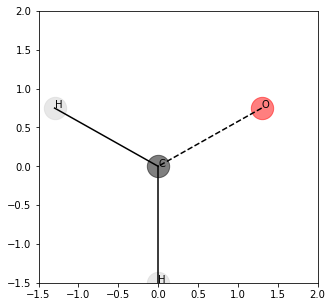

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
#     mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
#     print(p)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr_neighbor = torch.tensor(edge_attr).unsqueeze(0).T
                              
p_neighbor = torch.tensor(atom_pos)
x_neighbor = torch.tensor(atom_attr)                              
x_focal = x_focal.unsqueeze(0)
# print(p)
# print(origin)
# print(x)
  
    
#============generate a list of same receptive field 
data = Data(p_neighbor=p_neighbor, x_neighbor=x_neighbor, x_focal=x_focal, edge_attr_neighbor=edge_attr_neighbor, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p_neighbor, i)
    data = Data(p = new_p, p_focal = p_focal, x_neighbor=x_neighbor, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)







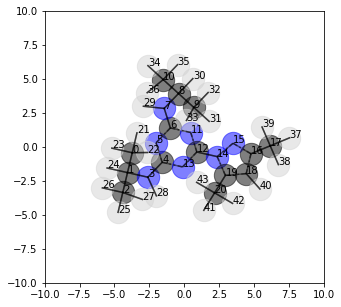

In [4]:
x =torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])  
p = torch.tensor([[-3.7256, -0.4303],                                                                                                                                                                                                [-4.0641, -1.8916],                                                                                                                                                                                                [-4.4027, -3.3529],                                                                                                                                                                                                [-2.6028, -2.2302],                                                                                                                                                                                                [-1.5790, -1.1339],                                                                                                                                                                                                [-2.0164,  0.3008],                                                                                                                                                                                                [-0.9926,  1.3971],                                                                                                                                                                                                [-1.4300,  2.8319],                                                                                                                                                                                                [-0.4062,  3.9281],                                                                                                                                                                                                [ 0.6900,  2.9043],                                                                                                                                                                                                [-1.5024,  4.9520],                                                                                                                                                                                                [ 0.4687,  1.0585],                                                                                                                                                                                                [ 0.9062, -0.3763],                                                                                                                                                                                                [-0.1177, -1.4725],                                                                                                                                                                                                [ 2.3675, -0.7148],                                                                                                                                                                                                [ 3.5003,  0.2684],                                                                                                                                                                                                [ 4.7854, -0.5051],                                                                                                                                                                                                [ 6.1666,  0.0799],                                                                                                                                                                                                [ 4.4469, -1.9664],                                                                                                                                                                                                [ 2.9525, -2.0960],                                                                                                                                                                                                [ 2.1789, -3.3812],                                                                                                                                                                                                [-3.3870,  1.0310],                                                                                                                                                                                                [-2.6322, -0.4120],                                                                                                                                                                                                [-5.1869, -0.0918],                                                                                                                                                                                                [-5.5254, -1.5531],                                                                                                                                                                                                [-4.7412, -4.8142],                                                                                                                                                                                                [-5.8640, -3.0144],                                                                                                                                                                                                [-2.9935, -3.8671],                                                                                                                                                                                                [-1.9937, -3.6010],                                                                                                                                                                                                [-2.9217,  2.9898],                                                                                                                                                                                                [ 0.6176,  5.0244],                                                                                                                                                                                                [ 1.7863,  1.8804],                                                                                                                                                                                                [ 1.7139,  4.0005],                                                                                                                                                                                                [ 0.1592,  1.9483],                                                                                                                                                                                                [-2.5987,  5.9758],                                                                                                                                                                                                [-0.4786,  6.0482],                                                                                                                                                                                                [-2.6523,  3.9887],                                                                                                                                                                                                [ 7.5479,  0.6649],                                                                                                                                                                                                [ 6.7517, -1.3013],                                                                                                                                                                                                [ 5.5816,  1.4611],                                                                                                                                                                                                [ 5.4301, -3.0993],                                                                                                                                                                                                [ 1.4054, -4.6663],                                                                                                                                                                                                [ 3.4641, -4.1547],                                                                                                                                                                                                [ 0.8938, -2.6076]])       
edge_index = torch.tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,                                                                                                                                             8, 10,  6, 11, 11, 12, 12, 13, 12, 14, 14, 15, 15, 16, 16, 17, 16, 18,                                                                                                                                            18, 19, 19, 20, 13,  4, 19, 14,  0, 21,  0, 22,  0, 23,  1, 24,  2, 25,                                                                                                                                             2, 26,  2, 27,  3, 28,  7, 29,  8, 30,  9, 31,  9, 32,  9, 33, 10, 34,                                                                                                                                            10, 35, 10, 36, 17, 37, 17, 38, 17, 39, 18, 40, 20, 41, 20, 42, 20, 43],                                                                                                                                          [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,                                                                                                                                            10,  8, 11,  6, 12, 11, 13, 12, 14, 12, 15, 14, 16, 15, 17, 16, 18, 16,                                                                                                                                            19, 18, 20, 19,  4, 13, 14, 19, 21,  0, 22,  0, 23,  0, 24,  1, 25,  2,                                                                                                                                            26,  2, 27,  2, 28,  3, 29,  7, 30,  8, 31,  9, 32,  9, 33,  9, 34, 10,                                                                                                                                            35, 10, 36, 10, 37, 17, 38, 17, 39, 17, 40, 18, 41, 20, 42, 20, 43, 20]])  
edge_attr = torch.tensor([[1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1]])    
data = Data(x = x, p= p , edge_index= edge_index, edge_attr = edge_attr)
vis_graph(data, lower_bound = -10, upper_bound = 10)



In [20]:
import torch

from torch_geometric.data import Data

from rdkit import Chem
import rdkit
# from rdkit import Chem
# # from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

import pandas as pd
import os

import random


def generate_1hop_kernel(D, typical_compound_smiles, center_atom_id, x_dim=None):
    #     '''
    #     given a typical compound containing a certain kernal, and the center atom id, genrate the kernel
    #     '''
    if D == None:
        raise Exception('generate_kernel2grpah() needs to input D to specifiy 2D or 3D graph generation.')

    smiles = typical_compound_smiles.replace(r'/=', '=')
    smiles = typical_compound_smiles.replace(r'\=', '=')

    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    # mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)

    if D == 2:
        Chem.rdDepictor.Compute2DCoords(mol)
    if D == 3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()

    all_atoms = mol.GetAtoms()
    center_atom = all_atoms[center_atom_id]
    # print(f'center atom:{center_atom.GetSymbol()}')

    atom_pos = []
    atom_attr = []

    supports = center_atom.GetNeighbors()

    if x_dim is None:
        x_center = get_atom_rep(center_atom.GetAtomicNum())
    else:
        x_center = [random.uniform(0, 1) for i in range(x_dim)]

    p_list = []
    x_list = []
    bond_attr_list = []
    # print()
    # print('atom idx:')
    # for i, atom in enumerate(all_atoms):
    #     print(f'{atom.GetIdx()}, {atom.GetSymbol()}')

    for idx, edge in enumerate(center_atom.GetBonds()):
        support_start_id = edge.GetBeginAtomIdx()
        support_end_id = edge.GetEndAtomIdx()
#         print(f'support_start_id:{support_start_id}')
#         print(f'support_end_id:{support_end_id}')
        if (support_start_id == center_atom_id):
            support_id = support_end_id
        else:
            support_id = support_start_id
        support = all_atoms[support_id]
        if x_dim is None:
            x_list.append(get_atom_rep(support.GetAtomicNum()))
        else:
            x_list.append([random.uniform(0, 1) for i in range(x_dim)])
        if D == 2:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y - conf.GetAtomPosition(center_atom_id).y])
        if D == 3:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y -
                                       conf.GetAtomPosition(center_atom_id).y, conf.GetAtomPosition(support_id).z - conf.GetAtomPosition(center_atom_id).z])

        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]
        bond_attr_list.append(bond_attr)

    x_center = torch.tensor(x_center).unsqueeze(0).unsqueeze(0)
    x_support = torch.tensor(x_list).unsqueeze(0)
    p_support = torch.tensor(p_list).unsqueeze(0)
    edge_attr_support = torch.tensor(bond_attr_list, dtype=p_support.dtype).unsqueeze(0)

#     print('x_center')
#     print(x_center)
#     print('x_support')
#     print(x_support)
#     print('p_support')
#     print(p_support)
#     print('edge_attr_support')
#     print(edge_attr_support)
    data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
    return data  # x_center, x_support, p_support, edge_attr_support


def generate_kernel_with_angle_and_length_and_edge_attr(D, typical_compound_smiles, center_atom_id, x_dim):
    '''
    generate a kernel with typical angle and lenth and edge_attr, but randomize x attribute
    '''
    return generate_1hop_kernel(D, typical_compound_smiles, center_atom_id, x_dim=x_dim)


def read_kernel_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    df = df.transpose()
    kernel_dict = df.to_dict(orient='list')
    return kernel_dict


def print_kernel_files():
    root = 'customized_kernels'
    files = os.listdir(root)
    for file in files:
        df = pd.read_csv(root + '/' + file)
        print(df)


# degree1
hop1_degree1_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel1.csv')

# degree2
hop1_degree2_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel2.csv')


# degree3
hop1_degree3_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel3.csv')


# degree4
hop1_degree4_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel4.csv')


# ===1hop kernels - 2D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_2D_degree1_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_2D_degree2_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_2D_degree3_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_2D_degree4_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]

# ===1hop kernels - 3D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_3D_degree1_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_3D_degree2_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_3D_degree3_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_3D_degree4_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]


def get_hop1_kernel_list(D):
    if D == 2:
        # to make sure the original list is untouched, use the copied one
        return hop1_2D_degree1_kernels_list.copy(), hop1_2D_degree2_kernels_list.copy(), hop1_2D_degree3_kernels_list.copy(), hop1_2D_degree4_kernels_list.copy()
    elif D == 3:
        return hop1_3D_degree1_kernels_list.copy(), hop1_3D_degree2_kernels_list.copy(), hop1_3D_degree3_kernels_list.copy(), hop1_3D_degree4_kernels_list.copy()
    else:
        raise Exception('get_hop1_kernel_list(): invalid D')




In [17]:
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList, CosineSimilarity, Module, ModuleList, Linear, Sigmoid
# from torch.nn import
from torch.nn.parameter import Parameter

from itertools import permutations
import math
import pandas as pd

import os



torch.autograd.set_detect_anomaly(True)

class KernelConv(Module):
    def __init__(self, L=None, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel=None, requires_grad=True, init_length_sc_weight = 0.1, init_angle_sc_weight = 0.5,  init_center_attr_sc_weight = 0.8, init_support_attr_sc_weight = 0.8, init_edge_attr_support_sc_weight=0.8, weight_requires_grad= False):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (L is None) or (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception(
                    'either numer of kernels L, convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center=torch.randn(L, 1, node_attr_dim), x_support=torch.randn(
                    L, num_supports, node_attr_dim), edge_attr_support=torch.randn(L, num_supports, edge_attr_dim), p_support=torch.randn(L, num_supports, D))

        self.num_kernels = init_kernel.x_center.shape[0]

        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor, requires_grad=requires_grad)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor, requires_grad=requires_grad)

        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor, requires_grad=requires_grad)

        p_support_tensor = init_kernel.p_support
#         print(f'p_support_tensor:{p_support_tensor.shape}')
        self.p_support = Parameter(p_support_tensor, requires_grad=requires_grad)

        self.length_sc_weight = Parameter(torch.tensor(init_length_sc_weight), requires_grad = weight_requires_grad)
        self.angle_sc_weight = Parameter(torch.tensor(init_angle_sc_weight), requires_grad = weight_requires_grad)
        self.center_attr_sc_weight = Parameter(torch.tensor(init_center_attr_sc_weight), requires_grad = weight_requires_grad)
        self.support_attr_sc_weight = Parameter(torch.tensor(init_support_attr_sc_weight), requires_grad = weight_requires_grad)
        self.edge_attr_support_sc_weight = Parameter(torch.tensor(init_edge_attr_support_sc_weight), requires_grad = weight_requires_grad)

    def get_num_kernels(self):
        return self.num_kernels

    def permute(self, x):
        #         print('permute')
        #         print('x')
        #         print(x.shape)
        rows = x.shape[1]
        l = [x[:, torch.tensor(permute), :]
             for permute in list(permutations(range(rows)))]
        output = torch.stack(l, dim=1)
#         print('permuted')
#         print(output.shape)
        return output

    def intra_angle(self, p):
        '''
        angles between each row vectors
        '''
        cos = CosineSimilarity(dim=-1)
        new_p = torch.roll(p, 1, dims=-2)
#         print(f'new p:')
#         print(new_p)
        sc = cos(new_p, p)
#         print(f'intra angle sc:{sc.shape}')
        return sc

    def arctan_sc(self, tensor1, tensor2, dim=None):
        diff = torch.square(tensor1 - tensor2)
#         print(diff)
        if dim is not None:
            sc = torch.sum(diff, dim=dim)
        else:
            sc = torch.sum(diff)
        sc = torch.atan(1 / (sc+1e-8))
        return sc

    def get_angle_score(self, p_neighbor, p_support):
        #         print('get_angle_score')
        #         print(f'p_neighbor:{p_neighbor.shape}')
        #         print(p_neighbor.shape)
        #         print(f'p_support:{p_support.shape}')
        #         print(p_support.shape)
        if(p_support.shape[-2] == 1):
            return torch.full((p_support.shape[0], p_neighbor.shape[0]), math.pi / 2, device=p_neighbor.device)
#         cos = CosineSimilarity(dim = 1)

        p_neighbor = p_neighbor.unsqueeze(0).unsqueeze(0).expand(
            p_support.shape[0], p_support.shape[1], p_neighbor.shape[-3], p_neighbor.shape[-2], p_neighbor.shape[-1])
#         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape)
#         print(f'p_neighbor:{p_neighbor.shape}')
        intra_p_neighbor_angle = self.intra_angle(p_neighbor)
#         intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
#         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')

#         p_support = p_support.expand(p_neighbor.shape)
#         print(f'p_support:{p_support.shape}')
        intra_p_support_angle = self.intra_angle(p_support)
#         intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
#         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

#         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
#         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
        sc = self.arctan_sc(intra_p_neighbor_angle,
                            intra_p_support_angle, dim=(-1))
#         print(f'inner angle_sc:{sc.shape}')
        return sc.squeeze(1)

    def get_length_score(self, p_neighbor, p_support):
        len_p_neighbor = torch.norm(p_neighbor, dim=-1)
        len_p_support = torch.norm(p_support, dim=-1)

#         print('len_p_neighbor')
#         print(f'len_p_neighbor:{len_p_neighbor.shape}')
#         print(f'len_p_support:{len_p_support.shape}')

        # inverse of L2 norm
        sc = self.arctan_sc(len_p_neighbor, len_p_support, dim=(-1))
#         diff = torch.square(len_p_neighbor - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)

# #         print(sc)
        return sc

    def get_support_attribute_score(self, x_nei, x_support):
        #         print(f'x_nei:{x_nei.shape}')
        #         print(f'x_suppport:{x_support.shape}')
        x_nei = x_nei.unsqueeze(0).unsqueeze(0).expand(
            x_support.shape[0], x_support.shape[1], x_nei.shape[0], x_nei.shape[1], x_nei.shape[2])
        x_support = x_support.unsqueeze(2).expand(x_nei.shape)

        sc = self.arctan_sc(x_nei, x_support, dim=(-2, -1))
        return sc

    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
        #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
        #         print(f'x_focal:{x_focal.shape}, x_center:{x_center.shape}')
        #         print(x_focal)
        #         print(x_center)
        #         diff = torch.square(x_focal - x_center)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        x_focal = x_focal.unsqueeze(0).expand(
            x_center.shape[0], x_focal.shape[0], x_focal.shape[1])
        x_center = x_center.expand(x_focal.shape)
#         print('x_focal')
#         print(x_focal)
#         print('x_center')
#         print(x_center)

        sc = self.arctan_sc(x_focal, x_center, dim=(-1))
        return sc

    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
        #         print('edge_attr_nei')
        #         print(edge_attr_nei)
        #         print('edge_attr_support')
        #         print(edge_attr_support)
        #         diff = torch.square(edge_attr_nei - edge_attr_support)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim=(-2, -1))
        return sc

    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal.unsqueeze(1)

        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support

        # print('=====cal total sc')
        # print(f'x_center:{x_center.shape}')
        # print(f'x_support:{x_support.shape}')
        # print(f'edge_attr_support:{edge_attr_support.shape}')
        # print(f'p_support:{p_support.shape}')
        # print('\n')
        # print(f'x_focal:{x_focal.shape}')
        # print(f'p_focal:{p_focal.shape}')
        # print(f'x_neighbor:{x_neighbor.shape}')
        # print(f'p_neighbor:{p_neighbor.shape}')
        # print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')

        # because every sub-score is calculated using actan function, which peaks at pi/2, so this max_atn is used to normalized the score so it is in [0,1]
        max_atan = torch.tensor([math.pi / 2], device=p_neighbor.device)

        # calculate the support attribute score
        permuted_x_support = self.permute(x_support)
#         print(f'permuted_x_support:{permuted_x_support.shape}')
        support_attr_sc = self.get_support_attribute_score(x_neighbor, permuted_x_support) / max_atan
#         print(f'support_attr_sc:{support_attr_sc}')
        # get the best support_attr_sc and its index
        best_support_attr_sc, best_support_attr_sc_index = torch.max(support_attr_sc, dim=1)
#         print(f'best_support_attr_sc:{best_support_attr_sc}, index:{best_support_attr_sc_index.shape}')
        # print(f'index:{best_support_attr_sc_index}')

        # calculate the angle score
        permuted_p_support = self.permute(p_support)
        permuted_p_support = permuted_p_support.unsqueeze(2).expand(
            permuted_p_support.shape[0], permuted_p_support.shape[1], best_support_attr_sc_index.shape[1], permuted_p_support.shape[2], permuted_p_support.shape[3])
#         print(f'permuted_p_support:{permuted_p_support}')
        selected_index = best_support_attr_sc_index.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(
            permuted_p_support.shape[0], 1, best_support_attr_sc_index.shape[-1], permuted_p_support.shape[3], permuted_p_support.shape[4])
        best_p_support = torch.gather(permuted_p_support, 1, selected_index)
#         print(f'best_p_support:{best_p_support}')
        angle_sc = self.get_angle_score(p_neighbor, best_p_support) / max_atan
        # print(f'angle_sc.shape:{angle_sc.shape}')

        # calculate length
        best_p_support = best_p_support.squeeze(1)
#         print(f'best_p_support:{best_p_support.shape}')
        length_sc = self.get_length_score(p_neighbor, best_p_support) / max_atan
        # print(f'length_sc.shape:{length_sc.shape}')

        # calculate the center attribute score
#         print(f'x_center:{x_center.shape}')
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center) / max_atan
        # print(f'center_attr_sc.shape:{center_attr_sc.shape}')

        # calculate the edge attribute score
        selected_index = best_support_attr_sc_index.unsqueeze(-1).unsqueeze(-1).expand(
            best_support_attr_sc_index.shape[0], best_support_attr_sc_index.shape[1], edge_attr_support.shape[-2], edge_attr_support.shape[-1])
#         print(f'edge_attr_support:{edge_attr_support.shape}')
        permuted_edge_attr_support = self.permute(edge_attr_support)
#         print(f'permuted:{permuted_edge_attr_support.shape}')
#         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
        best_edge_attr_support = torch.gather(
            permuted_edge_attr_support, 1, selected_index)
#         print(f'best_edge_attr_support:{selected_index.shape}')
#         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')
#         print(f'best_edge_attr_support:{best_edge_attr_support.shape}')
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr_neighbor, best_edge_attr_support) / max_atan
        # print(f'edge_attr_support_sc.shape:{edge_attr_support_sc.shape}')


#         # convert each score to correct dimension
#         angle_sc = angle_sc
#         length_sc = length_sc
        support_attr_sc = best_support_attr_sc  # .unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc
#         edge_attr_support_sc = edge_attr_support_sc

        # the maxium value a arctain function can get

        one = torch.tensor([1], device=p_neighbor.device)
        sc = torch.atan(1 /

                        (torch.square(length_sc - one) * self.length_sc_weight +
                         torch.square(angle_sc - one) * self.angle_sc_weight +
                         torch.square(support_attr_sc - one) * self.support_attr_sc_weight +
                         torch.square(center_attr_sc - one) * self.center_attr_sc_weight +
                         torch.square(edge_attr_support_sc - one) * self.edge_attr_support_sc_weight
                         + 1e-8
                         ))


        # sc = torch.atan(1 /
        #                 (torch.square(length_sc - max_atan) +
        #                  torch.square(angle_sc - max_atan) +
        #                  torch.square(support_attr_sc - max_atan) +
        #                  torch.square(center_attr_sc - max_atan) +
        #                  torch.square(edge_attr_support_sc - max_atan)
        #                  )).squeeze(0)
        sc = sc / max_atan  # normalize the score to be in [0,1]


        return sc, length_sc, angle_sc, support_attr_sc, center_attr_sc, edge_attr_support_sc

    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr_neighbor = kwargv['edge_attr_neighbor']

        if(p_focal.shape[-1] != self.p_support.shape[-1]):
            raise Exception(f'data coordinates is of {p_focal.shape[-1]}D, but the kernel is {self.p_support.shape[-1]}D')


#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(
            x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)

        # print('\n')
        # print(f'len sc:{length_sc}')
        # print(f'angle sc:{angle_sc}')
        # print(f'support attribute_sc:{supp_attr_sc}')
        # print(f'center_attr_sc:{center_attr_sc}')
        # print(f'edge attribute score:{edge_attr_support_sc}')
        # print(f'total sc: {sc.shape}')
        return sc  # , length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


class BaseKernelSetConv(Module):
    # , trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None, ):
    def __init__(self, fixed_kernelconv1=None, fixed_kernelconv2=None, fixed_kernelconv3=None, fixed_kernelconv4=None, trainable_kernelconv1=None, trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None):
        super(BaseKernelSetConv, self).__init__()

        self.fixed_kernelconv_set = ModuleList([fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3, fixed_kernelconv4])
        self.num_fixed_kernel_list = []
        if (fixed_kernelconv1 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv1.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv2 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv2.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv3 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv3.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv4 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv4.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)

        # if (trainable_kernelconv1 is not None) and (trainable_kernelconv2 is not None) and (trainable_kernelconv3 is not None) and (trainable_kernelconv4 is not None):
        #     self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4]
        #                                                )  # , trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        #     self.num_trainable_kernel_list = [trainable_kernelconv1.get_num_kernels(), trainable_kernelconv2.get_num_kernels(),
        #                                       trainable_kernelconv3.get_num_kernels(), trainable_kernelconv4.get_num_kernels()]
        # else:
        #     self.trainable_kernelconv_set = ModuleList([])
        #     self.num_trainable_kernel_list = []

        self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        self.num_trainable_kernel_list = []
        if (trainable_kernelconv1 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv1.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv2 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv2.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv3 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv3.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv4 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv4.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)

        # num of kernels for each degree, combining both fixed and trainable kerenls
        self.num_kernel_list = []
        for i in range(4):
            num = 0
            if(self.num_fixed_kernel_list[i] is not None):
                num = self.num_fixed_kernel_list[i]
            if(self.num_trainable_kernel_list[i] is not None):
                num += self.num_trainable_kernel_list[i]
            self.num_kernel_list.append(num)



        print(f'self.num_kernel_list:{self.num_kernel_list}')
#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        # print(f'edge_index:{edge_index.shape}, x:{x.shape}')
        deg = degree(edge_index[0], x.shape[0])
        return deg

    def get_neighbor_index(self, edge_index, center_index):
        #         print('edge_index')
        #         print(edge_index)
        #         print('\n')
        #         print('center_index')
        #         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]
        return edge_index[1, d]

    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input=x, dim=0, index=selected_index[0])
        p_focal = torch.index_select(input=p, dim=0, index=selected_index[0])

        return x_focal, p_focal, selected_index[0]

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]

        # normalize bond id
        e = (d / 2).long()
#         bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
        bond_id = torch.tensor([2 * x for x in e], device=a.device)
#         print('bond_id')
#         print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(
            input=edge_attr, dim=0, index=bond_id)

        return nei_edge_attr

    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph

        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)

        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
#             print(f'nei_index:{nei_index.shape}')

            nei_x = torch.index_select(x, 0, nei_index)
#             print(f'nei_x:{nei_x.shape}')
            nei_p = torch.index_select(p, 0, nei_index)
#             print(f'nei_p:{nei_p.shape}')
            nei_edge_attr = self.get_edge_attr_support_from_center_node(
                edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)

            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)

        nei_x = torch.stack(nei_x_list, dim=0)
        nei_p = torch.stack(nei_p_list, dim=0)
        nei_edge_attr = torch.stack(
            nei_edge_attr_list, dim=0)

#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)

        return nei_x, nei_p, nei_edge_attr

    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal, selected_index = self.get_focal_nodes_of_degree(
            deg=deg, x=x, p=p, edge_index=edge_index)

        num_focal = x_focal.shape[0]
        # print(f'num_focal:{num_focal}')
        if num_focal != 0:
            x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(
                deg=deg, x=x, edge_index=edge_index, p=p, edge_attr=edge_attr)
#             print(f'x_neighbor:{x_neighbor.shape}')
#             print(f'p_neighbor:{p_neighbor.shape}')
            return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index
        return None

    def get_reorder_index(self, index):
        '''
        get the index to rearrange output score matrix so that it corespond to the order in the original x matrix

        '''
        rearranged, new_index = torch.sort(index, dim=0)

        return new_index

    def format_output(self, output):
        '''
        change the shape of output from (L, num_nodes, 4) to (num_nodes, 4*L)
        '''
        a = [output[i, :, :] for i in range(output.shape[0])]
        return torch.cat(a, dim=1)

    def save_score(self, sc):
        root = 'customized_kernels'
        print('saving score...')
        sc_np = sc.cpu().detach().numpy()
        files = os.listdir(root)
        headers = []
        for i, file in enumerate(files):
            names = list(pd.read_csv(root + '/' + file)['name'])
            headers += names
            rand_names = ['std_kernel'] * self.num_trainable_kernel_list[i]
            headers += rand_names
        print(headers)
        sc_df = pd.DataFrame(sc_np, columns=headers)
        sc_df = sc_df.transpose()
        sc_df.to_csv('scores.csv')

    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv) != 0:
            raise Exception(
                'Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 2:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
            save_score = kwargv['save_score']

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']

#         print('edge_index')
#         print(edge_index)

#         print('edge_attr')
#         print(edge_attr)

        # loop through all possbile degrees. i.e. 1 to 4 bonds
        sc_list = []
        index_list = []

        # print(f'sum(self.num_kernel_list):{sum(self.num_kernel_list)}')
        zeros = torch.zeros(sum(self.num_kernel_list), x.shape[0], device=p.device)
        # print('zeros')
        # print(zeros)
        start_row_id = 0
        start_col_id = 0
        for deg in range(1, 5):
            # print(f'deg:{deg}')
            receptive_field = self.convert_graph_to_receptive_field(deg, x, p, edge_index, edge_attr)
#             print('receptive_field')
#             print(receptive_field)
            if receptive_field is not None:
                x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index = receptive_field[
                    0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4], receptive_field[5]
                data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor,
                            p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor)

#                 print(f'selected_index:{selected_index.shape}')
#                 print('====data info====')
#                 print('x_focal')
#                 print(x_focal.shape)
#             print('p_focal')
#             print(p_focal)
#             print('x_neighbor')
#             print(x_neighbor)
#             print('p_neighbor')
#             print(p_neighbor)
#             print('edge_attr_neighbor')
#             print(edge_attr_neighbor)


                # print('===fixed_degree_sc===')
                if self.fixed_kernelconv_set[deg - 1] is not None:
                    fixed_degree_sc = self.fixed_kernelconv_set[deg - 1](data=data)
                    if self.trainable_kernelconv_set[deg - 1] is not None:
                        # print('---trainable_degree_sc---')
                        trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                        # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                        degree_sc = torch.cat([fixed_degree_sc, trainable_degree_sc])
                    else:
                        degree_sc = fixed_degree_sc
                else:

                    if self.trainable_kernelconv_set[deg - 1] is not None:
                        # print('---trainable_degree_sc---')
                        trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                        # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                        degree_sc = trainable_degree_sc

                    else:
                        raise Exception (f'both fixed and trainable kernelconv_set are None for degree {deg}')

                zeros[start_row_id:start_row_id + self.num_kernel_list[deg - 1], start_col_id:start_col_id + x_focal.shape[0]] = degree_sc

                index_list.append(selected_index)
                start_row_id += self.num_kernel_list[deg - 1]
                start_col_id += x_focal.shape[0]
            else:

                start_row_id += self.num_kernel_list[deg - 1]

        sc = zeros



        index_list = torch.cat(index_list)

        new_index = self.get_reorder_index(index_list)

        sc = sc[:, new_index]
        sc = sc.T

        # print(f'sc:{sc}')
        if(save_score == True):
            self.save_score(sc)  # save scores for analysis
        return sc


class KernelSetConv(BaseKernelSetConv):
    def __init__(self, L1, L2, L3, L4, D, node_attr_dim, edge_attr_dim):

        self.L = [L1, L2, L3, L4]

    # test of std kernel
        p_support = torch.tensor([[1.2990e+00, 7.5000e-01]]).unsqueeze(0)
        # print(p_support)

        x_center = torch.tensor([[16, 32.067, 1.8, 2, 6]]).unsqueeze(0)

        x_support = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor([[2]], dtype=torch.float).unsqueeze(0)

        kernel1_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

        p_support = torch.tensor([[1.2990e+00, 7.5000e-01],
                                  [-1.2990e+00, 7.5000e-01],
                                  [-2.7756e-16, -1.5000e+00]]).unsqueeze(0)
        # print(p_support)

        x_support = torch.tensor([[16, 32.067, 1.8, 2, 6],
                                  [6.0000, 12.0110, 1.7000, 4.0000, 4.0000],
                                  [1.0000, 1.0080, 1.2000, 1.0000, 1.0000]]).unsqueeze(0)

        x_center = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor(
            [[2], [1], [1]], dtype=torch.float).unsqueeze(0)

        kernel3_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

    #         kernel1 = KernelConv(init_kernel = kernel1_std)
        kernelconv1 = KernelConv(L=L1, D=D, num_supports=1, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv2 = KernelConv(L=L2, D=D, num_supports=2, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)

        kernelconv3 = KernelConv(L=L3, D=D, num_supports=3, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv4 = KernelConv(L=L4, D=D, num_supports=4, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        super(KernelSetConv, self).__init__(kernelconv1, kernelconv2, kernelconv3, kernelconv4)


class Predefined1HopKernelSetConv(BaseKernelSetConv):
    def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0):

        # generate functional kernels
        # degree1 kernels

        fixed_kernel1_list = get_hop1_kernel_list(D)[0]
        trainable_kernel1_list = [fixed_kernel1_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L1 != 0:
            trainable_kernel1_list *= L1  # duplicate the one-member list to have L1 members
            self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv1 = None
        self.fixed_kernel1 = self.cat_kernels(fixed_kernel1_list)
        fixed_kernelconv1 = KernelConv(init_kernel=self.fixed_kernel1, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel1.x_center.shape[0]} degree1 fixed kernels, {L1} degree1 trainable kernels')

        # degree2 kernels
        fixed_kernel2_list = get_hop1_kernel_list(D)[1]
        trainable_kernel2_list = [fixed_kernel2_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L2 != 0:
            trainable_kernel2_list *= L2  # duplicate the one-member list to have L2 members
            self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv2 = None
        self.fixed_kernel2 = self.cat_kernels(fixed_kernel2_list)
        fixed_kernelconv2 = KernelConv(init_kernel=self.fixed_kernel2, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel2.x_center.shape[0]} degree2 fixed kernels, {L2} degree2 trainable kernels')

        # degree3 kernels
        fixed_kernel3_list = get_hop1_kernel_list(D)[2]
        trainable_kernel3_list = [fixed_kernel3_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L3 != 0:
            trainable_kernel3_list *= L3  # duplicate the one-member list to have L3 members
            self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv3 = None
        self.fixed_kernel3 = self.cat_kernels(fixed_kernel3_list)
        fixed_kernelconv3 = KernelConv(init_kernel=self.fixed_kernel3, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel3.x_center.shape[0]} degree3 fixed kernels, {L3} degree3 trainable kernels')

        # degree4 kernels
        fixed_kernel4_list = get_hop1_kernel_list(D)[3]
        trainable_kernel4_list = [fixed_kernel4_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L4 != 0:
            trainable_kernel4_list *= L4  # duplicate the one-member list to have L4 members
            self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv4 = None
        self.fixed_kernel4 = self.cat_kernels(fixed_kernel4_list)
        fixed_kernelconv4 = KernelConv(init_kernel=self.fixed_kernel4, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel4.x_center.shape[0]} degree4 fixed kernels, {L4} degree4 trainable kernels')

        super(Predefined1HopKernelSetConv, self).__init__(fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3,
                                                          fixed_kernelconv4, trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4)

    def cat_kernels(self, kernel_list):
        x_center_list = [kernel.x_center for kernel in kernel_list]
        x_support_list = [kernel.x_support for kernel in kernel_list]
        p_support_list = [kernel.p_support for kernel in kernel_list]
        edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

        # for x_center in x_center_list:
        #     print(x_center.shape)
        x_center = torch.cat(x_center_list)
        x_support = torch.cat(x_support_list)
        p_support = torch.cat(p_support_list)
        edge_attr_support = torch.cat(edge_attr_support_list)
        data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
        return data

    def get_num_kernel(self):
        num_trainable_kernel = 0
        if hasattr(self, 'trainable_kernel1'):
            num_trainable_kernel = self.trainable_kernel1.x_center.shape[0]
        if hasattr(self, 'trainable_kernel2'):
            num_trainable_kernel += self.trainable_kernel2.x_center.shape[0]
        if hasattr(self, 'trainable_kernel3'):
            num_trainable_kernel += self.trainable_kernel3.x_center.shape[0]
        if hasattr(self, 'trainable_kernel4'):
            num_trainable_kernel += self.trainable_kernel4.x_center.shape[0]

        total_num = self.fixed_kernel1.x_center.shape[0] + self.fixed_kernel2.x_center.shape[0] + self.fixed_kernel3.x_center.shape[0] + self.fixed_kernel4.x_center.shape[0] + num_trainable_kernel
        # print(f'total number kernels:{total_num}')
        return total_num

class PredefinedNHopKernelSetConv(BaseKernelSetConv):
    '''
    The main difference between a PredefinedNHopKernelSetConv(abbreviated as NHop for simplicity) and Predefined1HopKernelSetConv(abbreviated as 1Hop for simplicity)
    is that 1HOP has some fixed kernels but NHop has all trainable but predefined kernels.
    '''
    def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0):

        # generate functional kernels
        # degree1 kernels
        typical_smiles = 'C[H]'
        typical_center_atom_id = 1
        trainable_kernel1_list = []
        if L1 != 0:
            for i in range(L1):
                trainable_kernel1 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel1_list.append(trainable_kernel1)
            self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv1 = None
        print(f'PredefinedNHopKernelSetConv: there are {L1} degree1 trainable kernels')


        # degree2 kernels
        # degree2 kernels
        typical_smiles = 'CO[H]'
        typical_center_atom_id = 1
        trainable_kernel2_list = []
        if L2 != 0:
            for i in range(L2):
                trainable_kernel2 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel2_list.append(trainable_kernel2)
            self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv2 = None
        print(f'PredefinedNHopKernelSetConv: there are {L2} degree2 trainable kernels')

        # degree3 kernels
        typical_smiles = 'C=C'
        typical_center_atom_id = 1
        trainable_kernel3_list = []
        if L3 != 0:
            for i in range(L3):
                trainable_kernel3 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel3_list.append(trainable_kernel3)
            self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv3 = None
        print(f'PredefinedNHopKernelSetConv: there are {L3} degree3 trainable kernels')

        # degree4 kernels
        typical_smiles = 'CC'
        typical_center_atom_id = 1
        trainable_kernel4_list = []
        if L4 != 0:
            for i in range(L4):
                trainable_kernel4 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel4_list.append(trainable_kernel4)
            self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv4 = None
        print(f'PredefinedNHopKernelSetConv: there are {L4} degree4 trainable kernels')

        super(PredefinedNHopKernelSetConv, self).__init__(trainable_kernelconv1=trainable_kernelconv1, trainable_kernelconv2=trainable_kernelconv2, trainable_kernelconv3=trainable_kernelconv3, trainable_kernelconv4=trainable_kernelconv4)

    def cat_kernels(self, kernel_list):
        x_center_list = [kernel.x_center for kernel in kernel_list]
        x_support_list = [kernel.x_support for kernel in kernel_list]
        p_support_list = [kernel.p_support for kernel in kernel_list]
        edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

        # for x_center in x_center_list:
        #     print(x_center.shape)
        x_center = torch.cat(x_center_list)
        x_support = torch.cat(x_support_list)
        p_support = torch.cat(p_support_list)
        edge_attr_support = torch.cat(edge_attr_support_list)
        data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
        return data

    def get_num_kernel(self):
        num_trainable_kernel = 0
        if hasattr(self, 'trainable_kernel1'):
            num_trainable_kernel = self.trainable_kernel1.x_center.shape[0]
        if hasattr(self, 'trainable_kernel2'):
            num_trainable_kernel += self.trainable_kernel2.x_center.shape[0]
        if hasattr(self, 'trainable_kernel3'):
            num_trainable_kernel += self.trainable_kernel3.x_center.shape[0]
        if hasattr(self, 'trainable_kernel4'):
            num_trainable_kernel += self.trainable_kernel4.x_center.shape[0]

        total_num = num_trainable_kernel
        # print(f'total number kernels:{total_num}')
        return total_num

# class KernelLayer(Module):
#     '''
#         a wrapper of KernelSetConv for clear input/output dimension, inputs:
#         D: dimension
#         L: number of KernelConvSet

#         the output will be of dimension L1+L2+L3+L4
#     '''

#     def __init__(self, x_dim, p_dim, edge_dim, L1=None, L2=None, L3=None, L4=None, predined_kernelsets=True):

#         super(KernelLayer, self).__init__()
#         if(predined_kernelsets == True):
#             self.conv = PredefinedKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)
#         else:
#             if L1 is None or L2 is None or L3 is None or L4 is None:
#                 raise Exception('KernelLayer(): if predined_kernelsets is false, then L1-L4 needs to be specified')
#             self.conv = KernelSetConv(L1, L2, L3, L4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)

#     def forward(self, data):
#         return self.conv(data=data)



In [8]:
# model.py
import torch
from torch.nn import ModuleList
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from torch_geometric.data import Data, DataLoader


class MolGCN(MessagePassing):
    def __init__(self, num_layers=5, num_kernel1=None, num_kernel2=None, num_kernel3=None, num_kernel4=None, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1):
        super(MolGCN, self).__init__(aggr='add')
        self.num_layers = num_layers
        if num_layers < 1:
            raise Exception('at least one convolution layer is needed')

        self.layers = ModuleList()

        self.num_kernerls_list = []
        # first layer
        if (num_kernel1 is not None) and (num_kernel2 is not None) and (num_kernel3 is not None) and (num_kernel4 is not None) and (predined_kernelsets == False):
            kernel_layer = KernelSetConv(num_kernel1, num_kernel2, num_kernel3, num_kernel4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim)
            num_kernels = num_kernel1 + num_kernel2 + num_kernel3 + num_kernel4
        elif (predined_kernelsets == True):
            kernel_layer = Predefined1HopKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim, L1=num_kernel1, L2=num_kernel2, L3=num_kernel3, L4=num_kernel4)
            num_kernels = kernel_layer.get_num_kernel()
        else:
            raise Exception('MolGCN: num_kernel1-4 need to be specified')

        self.layers.append(kernel_layer)
        self.num_kernerls_list.append(num_kernels)

        # second_layer
        # x_dim = num_kernels
        # for i in range(num_layers - 1):
        #     kernel_layer = KernelLayer(x_dim, p_dim, edge_attr_dim, num_kernel1, num_kernel2, num_kernel3, num_kernel4)
        #     self.layers.append(kernel_layer)

    def num_kernels(self, layer):
        return self.num_kernerls_list[layer]

    def forward(self, *argv, **kwargv):
        if len(argv) != 0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
            data = Data(x=x, p=p, edge_index=edge_index, edge_attr=edge_attr)
            # print(f'foward: data.x{data.x}')
            save_score = kwargv['save_score']
        h = x

        for i in range(self.num_layers):
            print(f'{i}th layer')
            data.x = h

            kernel_layer = self.layers[i]
            sim_sc = kernel_layer(data=data, save_score=save_score)
            # print(f'edge_index:{edge_index.device}, sim_sc:{sim_sc.device}')
            # print('sim_sc')
            # print(sim_sc)
            h = self.propagate(edge_index=edge_index, sim_sc=sim_sc)
            # print(f'h:{h}')
        return h

    def message(self, sim_sc_j):
        # print(f'sim_sc_j:{sim_sc_j.shape}')
        return sim_sc_j


class GNN_graphpred(torch.nn.Module):
    """
    Extension of GIN to incorporate edge information by concatenation.
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        num_tasks (int): number of tasks in multi-task learning scenario
        drop_ratio (float): dropout rate
        JK (str): last, concat, max or sum.
        graph_pooling (str): sum, mean, max, attention, set2set
        gnn_type: gin, gcn, graphsage, gat
    See https://arxiv.org/abs/1810.00826
    JK-net: https://arxiv.org/abs/1806.03536
    """

    def __init__(self, num_layers=1, num_kernel1=0, num_kernel2=0, num_kernel3=0, num_kernel4=0, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1, JK="last", drop_ratio=0, graph_pooling="mean"):
        super(GNN_graphpred, self).__init__()
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.D = p_dim

        if self.num_layers < 1:
            raise ValueError("GNN_graphpred: Number of GNN layers must be greater than 0.")

        self.gnn = MolGCN(num_layers=num_layers, num_kernel1=num_kernel1, num_kernel2=num_kernel2, num_kernel3=num_kernel3,
                          num_kernel4=num_kernel4, x_dim=x_dim, p_dim=p_dim, edge_attr_dim=edge_attr_dim, predined_kernelsets=predined_kernelsets)

        # Different kind of graph pooling
        if graph_pooling == "sum":
            self.pool = global_add_pool
        elif graph_pooling == "mean":
            self.pool = global_mean_pool
        elif graph_pooling == "max":
            self.pool = global_max_pool
        # elif graph_pooling == "attention":
        #     if self.JK == "concat":
        #         self.pool = GlobalAttention(gate_nn=torch.nn.Linear(
        #             (self.num_layer + 1) * emb_dim, 1))
        #     else:
        #         self.pool = GlobalAttention(
        #             gate_nn=torch.nn.Linear(emb_dim, 1))
        # elif graph_pooling[:-1] == "set2set":
        #     set2set_iter = int(graph_pooling[-1])
        #     if self.JK == "concat":
        #         self.pool = Set2Set((self.num_layer + 1)
        #                             * emb_dim, set2set_iter)
        #     else:
        #         self.pool = Set2Set(emb_dim, set2set_iter)
        else:
            raise ValueError("Invalid graph pooling type.")

        # For graph-level binary classification
        if graph_pooling[:-1] == "set2set":
            self.mult = 2
        else:
            self.mult = 1

        if self.JK == "concat":
            self.graph_pred_linear = torch.nn.Linear(
                self.mult * (self.num_layers + 1) * self.emb_dim, 1)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.gnn.num_kernels(-1), 1)

    def from_pretrained(self, model_file):
        # self.gnn = GNN(self.num_layer, self.emb_dim, JK = self.JK, drop_ratio = self.drop_ratio)
        self.gnn.load_state_dict(torch.load(model_file))

    def save_kernellayer(self, path):
        layers = self.gnn.layers
        print(f'{self.D}D, there are {len(layers)} layers')
        for i, layer in enumerate(layers):
            print(f'saving {i}th layer')
            torch.save(layer.state_dict(), f'{path}/{i}th_layer.pth')

    def forward(self, *argv, save_score=False):
        if len(argv) == 5:
            x, p, edge_index, edge_attr, batch = argv[0], argv[1], argv[2], argv[3], argv[4]
        elif len(argv) == 1:
            data = argv[0]
            x, p, edge_index, edge_attr, batch = data.x, data.p, data.edge_index, data.edge_attr, data.batch
        else:
            raise ValueError("unmatched number of arguments.")

        node_representation = self.gnn(x=x, edge_index=edge_index, edge_attr=edge_attr, p=p, save_score=save_score)
        # print(f'node_rep:{node_representation.shape}')
        graph_representation = self.pool(node_representation, batch)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'linear layer shape:{self.graph_pred_linear}')
        pred = self.graph_pred_linear(graph_representation)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'pred.grad:{pred.grad}')
        return pred, graph_representation




In [ ]:
# reset kernel

# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# manual data for weird angle testing
trans = torch.tensor([[1,1]])
# x= torch.tensor([[1],[1],[1],[1],[1],[1]], dtype = torch.float)
x= torch.tensor([[1],[1],[1],[1],[1]], dtype = torch.float)
# p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [0,0], [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1],[0,0],[0,2]])#, [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p+=trans
# edge_index = torch.tensor([[0,3,1,3,2,3, 5,2,2,4],[3,0,3,1,3,2,2,5,4,2]])
edge_index = torch.tensor([[0,3,1,3,2,3, 4,2],[3,0,3,1,3,2,2,4]])
# edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1]])
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)

# ========generate a list of graphs
origin = torch.tensor([0,0])
vis_graph(data)
data_list = []
for i in range(0, 370, 10):
    data = graph_rotate(data, origin, i)
    data_list.append(data)
#     vis_graph(data)


# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(L=10, D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)


# examine the model kernel
# x_center = model.state_dict()['kernel_set.2.x_center']
# x_support = model.state_dict()['kernel_set.2.x_support']
# edge_attr_support = model.state_dict()['kernel_set.2.edge_attr_support']
# p_support = model.state_dict()['kernel_set.2.p_support']
# m_kernel = Data(x_center= x_center, x_support = x_support, edge_attr_support = edge_attr_support, p_support = p_support)
# vis_kernel(m_kernel) # this visualize one single kernel
# # vis_kernel_in_model(model) # this visualize all kernels in the model


# run
# model(data = data)


# KernelConv test

In [ ]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random
from tqdm import tqdm

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.5)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
#         vis_graph(data)
#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        sc = model(data=data)
        label = torch.tensor([math.pi/2], dtype= torch.float)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        
#         print('before')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
            
        loss.backward()
        optimizer.step()
        
#         print('after')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
        
    print('\n')
    print(f'loss:{loss.item()}')
#     print(f'len sc:{length_sc.item()}')
#     print(f'angle sc:{angle_sc.item()}')
#     print(f'support attribute_sc:{supp_attr_sc.item()}')
#     print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'label:{label}')
    print(f'total sc: {sc}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


In [ ]:
vis_kernel_in_model(model)

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [ ]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)

In [ ]:
# visualize individual customized kernel
smiles = 'Cc1ccccc1'
center_atom_id =2

kernel = generate_1hop_kernel(2, smiles, center_atom_id)
# print(kernel)
# print(kernel.x_center.dtype, kernel.x_support.dtype, kernel.p_support.dtype, kernel.edge_attr_support.dtype)
vis_kernel(kernel, vis_element=True, only_graph=True)

x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True
# mol = Chem.MolFromSmiles(smiles, sanitize= False)
# mol.UpdatePropertyCache(strict=False)
# mol=Chem.AddHs(mol)
# mol


In [ ]:
# visualize all kernels in files
import os
root = 'customized_kernels'
files = os.listdir(root)
for file in files:
    path = root + '/' + file
    
    kernel_dict = read_kernel_from_csv(path)
    for key, value in kernel_dict.items():
        smiles = value[0]
        center_atom_id = value[1]
        kernel = generate_1hop_kernel(2, smiles, center_atom_id)
        vis_kernel(kernel, vis_element=True, only_graph=True)

In [ ]:

smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

model = GNN_graphpred()

In [6]:
# test of imbalance handling
from torch.utils.data import WeightedRandomSampler


numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print(f'target train 0/1: {len(np.where(target == 0)[0])} {len(np.where(target == 1)[0])}')

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print(f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")    
     



target train 0/1: 900 100


NameError: name 'DataLoader' is not defined

PredefinedNHopKernelSetConv: there are 15 degree1 trainable kernels
PredefinedNHopKernelSetConv: there are 15 degree2 trainable kernels
PredefinedNHopKernelSetConv: there are 15 degree3 trainable kernels
PredefinedNHopKernelSetConv: there are 15 degree4 trainable kernels
self.num_kernel_list:[15, 15, 15, 15]
['trainable_kernelconv_set.0.x_center', 'trainable_kernelconv_set.0.x_support', 'trainable_kernelconv_set.0.edge_attr_support', 'trainable_kernelconv_set.0.p_support', 'trainable_kernelconv_set.0.length_sc_weight', 'trainable_kernelconv_set.0.angle_sc_weight', 'trainable_kernelconv_set.0.center_attr_sc_weight', 'trainable_kernelconv_set.0.support_attr_sc_weight', 'trainable_kernelconv_set.0.edge_attr_support_sc_weight', 'trainable_kernelconv_set.1.x_center', 'trainable_kernelconv_set.1.x_support', 'trainable_kernelconv_set.1.edge_attr_support', 'trainable_kernelconv_set.1.p_support', 'trainable_kernelconv_set.1.length_sc_weight', 'trainable_kernelconv_set.1.angle_sc_weight', 'train

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


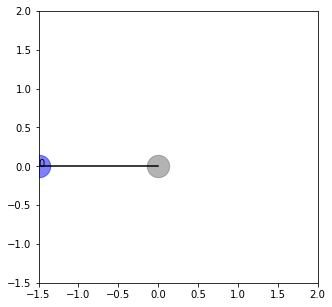

====0th kernel info====
0th-p_support:
torch.Size([1, 2])


0th-x_support:
tensor([[0.9185, 0.8021, 0.4650, 0.5238, 0.9196, 0.0907, 0.2987, 0.2607, 0.9245,
         0.2094, 0.1429, 0.5879, 0.6572, 0.7574, 0.5228, 0.3118, 0.2979, 0.6728,
         0.0194, 0.3046, 0.3098, 0.0784, 0.3622, 0.4692, 0.2763, 0.1124, 0.6857,
         0.1405, 0.1100, 0.4390, 0.8568, 0.3867, 0.1849, 0.4548, 0.8164, 0.2727,
         0.4114, 0.3528, 0.2246, 0.7855, 0.7450, 0.4960, 0.8076, 0.2032, 0.6919,
         0.0092, 0.5865, 0.7845, 0.7148, 0.4238, 0.2821, 0.1673, 0.5907, 0.1215,
         0.1028, 0.0701, 0.1432, 0.2343, 0.2956, 0.7095]])


0th-x_center:
tensor([[0.0890, 0.0245, 0.8551, 0.7239, 0.7287, 0.2261, 0.9663, 0.6019, 0.3812,
         0.3009, 0.0647, 0.3712, 0.9865, 0.0963, 0.1981, 0.5681, 0.1467, 0.6887,
         0.7524, 0.8809, 0.9418, 0.7261, 0.6779, 0.6568, 0.5607, 0.4266, 0.5170,
         0.9845, 0.3780, 0.0644, 0.2892, 0.5409, 0.6365, 0.9364, 0.7591, 0.1313,
         0.9878, 0.5596, 0.2841, 0.7884,

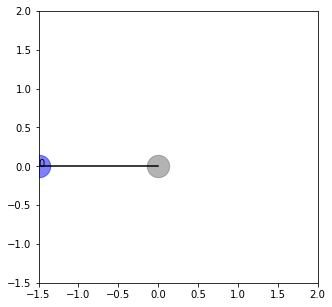

====1th kernel info====
1th-p_support:
torch.Size([1, 2])


1th-x_support:
tensor([[0.7003, 0.5160, 0.9435, 0.0193, 0.9719, 0.2839, 0.4737, 0.0279, 0.4389,
         0.9931, 0.9325, 0.9280, 0.5851, 0.2157, 0.2754, 0.8893, 0.3734, 0.8612,
         0.1782, 0.5124, 0.2222, 0.7840, 0.0067, 0.6762, 0.1570, 0.6315, 0.3444,
         0.8666, 0.8453, 0.3877, 0.6983, 0.5571, 0.5877, 0.7489, 0.8352, 0.1208,
         0.0424, 0.7104, 0.4454, 0.6290, 0.9474, 0.2840, 0.0605, 0.7204, 0.0287,
         0.2529, 0.7807, 0.8575, 0.3252, 0.1078, 0.4767, 0.4211, 0.9171, 0.6930,
         0.7342, 0.6385, 0.3506, 0.2845, 0.0362, 0.7375]])


1th-x_center:
tensor([[0.7948, 0.8056, 0.7725, 0.7347, 0.6419, 0.0473, 0.2442, 0.0976, 0.3813,
         0.5404, 0.0063, 0.1047, 0.3523, 0.5025, 0.7874, 0.3910, 0.4029, 0.9038,
         0.3214, 0.2685, 0.4065, 0.0511, 0.6792, 0.4522, 0.9362, 0.3058, 0.2407,
         0.5589, 0.6158, 0.3093, 0.2005, 0.2202, 0.2783, 0.8950, 0.8649, 0.7132,
         0.0582, 0.9348, 0.9858, 0.5372,

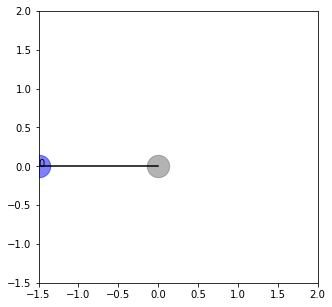

====2th kernel info====
2th-p_support:
torch.Size([1, 2])


2th-x_support:
tensor([[0.1177, 0.6121, 0.3479, 0.8789, 0.7314, 0.3395, 0.9742, 0.3591, 0.8869,
         0.0048, 0.2632, 0.2024, 0.7328, 0.0144, 0.3552, 0.4475, 0.9234, 0.3135,
         0.1922, 0.5033, 0.3194, 0.5476, 0.9506, 0.2582, 0.9854, 0.0826, 0.0894,
         0.3738, 0.2058, 0.5852, 0.2643, 0.8843, 0.9641, 0.7966, 0.9529, 0.9267,
         0.9881, 0.3721, 0.1459, 0.8798, 0.2636, 0.4292, 0.2044, 0.6552, 0.1671,
         0.4871, 0.4970, 0.2557, 0.3091, 0.9153, 0.8523, 0.2666, 0.1319, 0.3955,
         0.2928, 0.6179, 0.5262, 0.0584, 0.8653, 0.4321]])


2th-x_center:
tensor([[0.0218, 0.7088, 0.3617, 0.8482, 0.6774, 0.9777, 0.8902, 0.7286, 0.7545,
         0.4465, 0.7925, 0.5146, 0.3256, 0.0400, 0.4356, 0.5024, 0.8513, 0.2877,
         0.5483, 0.8918, 0.5399, 0.5956, 0.4616, 0.1967, 0.6541, 0.4828, 0.0296,
         0.3168, 0.2386, 0.7206, 0.7516, 0.7235, 0.1147, 0.3535, 0.4155, 0.6288,
         0.7058, 0.2832, 0.6963, 0.3028,

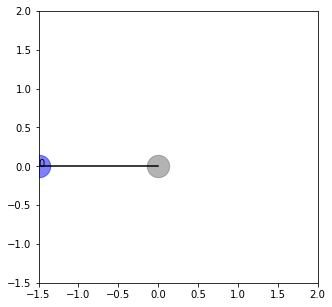

====3th kernel info====
3th-p_support:
torch.Size([1, 2])


3th-x_support:
tensor([[0.3289, 0.5074, 0.1938, 0.6464, 0.8710, 0.6814, 0.7301, 0.1958, 0.3518,
         0.8951, 0.0906, 0.7034, 0.8134, 0.6228, 0.3967, 0.7858, 0.6180, 0.5469,
         0.3262, 0.2040, 0.4524, 0.5968, 0.9339, 0.2297, 0.1404, 0.0936, 0.9565,
         0.7071, 0.4039, 0.4037, 0.5312, 0.7772, 0.6696, 0.2014, 0.0173, 0.2861,
         0.0511, 0.3870, 0.7565, 0.1940, 0.5561, 0.7381, 0.9779, 0.1468, 0.2024,
         0.4753, 0.5952, 0.0907, 0.3170, 0.1305, 0.7699, 0.2431, 0.1686, 0.8096,
         0.6447, 0.9175, 0.4358, 0.5607, 0.2973, 0.8179]])


3th-x_center:
tensor([[0.2316, 0.9338, 0.4376, 0.1974, 0.4138, 0.1049, 0.2049, 0.6957, 0.1337,
         0.1673, 0.1979, 0.7995, 0.1761, 0.0212, 0.6534, 0.1491, 0.4963, 0.5948,
         0.8584, 0.3235, 0.3184, 0.0191, 0.7537, 0.6402, 0.8483, 0.8141, 0.6950,
         0.1880, 0.1782, 0.9266, 0.5858, 0.9018, 0.2350, 0.2779, 0.8339, 0.2798,
         0.5132, 0.4618, 0.1351, 0.9200,

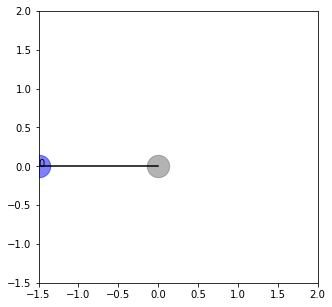

====4th kernel info====
4th-p_support:
torch.Size([1, 2])


4th-x_support:
tensor([[0.6708, 0.8974, 0.7045, 0.8275, 0.9060, 0.8734, 0.1972, 0.5829, 0.4831,
         0.5547, 0.2702, 0.0082, 0.4114, 0.3735, 0.6711, 0.6079, 0.7821, 0.5182,
         0.8978, 0.0415, 0.4620, 0.5896, 0.3086, 0.1250, 0.8558, 0.6877, 0.6154,
         0.1683, 0.5482, 0.0618, 0.0742, 0.4734, 0.3374, 0.9421, 0.5730, 0.1467,
         0.8197, 0.5418, 0.0030, 0.2203, 0.3264, 0.9738, 0.1618, 0.5461, 0.7996,
         0.7131, 0.3295, 0.2385, 0.2137, 0.7089, 0.8014, 0.4616, 0.5443, 0.7569,
         0.5151, 0.6128, 0.5275, 0.8337, 0.8166, 0.8559]])


4th-x_center:
tensor([[0.6974, 0.3726, 0.0448, 0.5366, 0.1462, 0.2116, 0.6528, 0.1328, 0.1941,
         0.4915, 0.5464, 0.8322, 0.7659, 0.4472, 0.2060, 0.4280, 0.4651, 0.8362,
         0.2561, 0.1168, 0.4831, 0.6929, 0.3354, 0.8688, 0.8469, 0.8124, 0.4475,
         0.3907, 0.7213, 0.9038, 0.7826, 0.5642, 0.2364, 0.0048, 0.7268, 0.3278,
         0.2029, 0.7193, 0.1898, 0.3154,

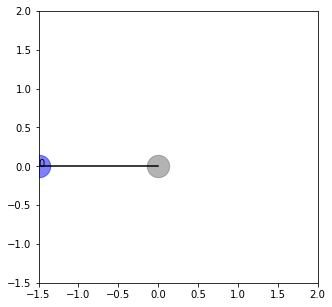

====5th kernel info====
5th-p_support:
torch.Size([1, 2])


5th-x_support:
tensor([[0.6148, 0.6679, 0.7346, 0.7575, 0.0930, 0.7794, 0.7825, 0.7042, 0.3968,
         0.3173, 0.4091, 0.0417, 0.0593, 0.9445, 0.4845, 0.4992, 0.8578, 0.7705,
         0.2628, 0.0861, 0.0455, 0.1617, 0.5288, 0.4967, 0.1227, 0.5214, 0.0105,
         0.4810, 0.2278, 0.5327, 0.3324, 0.5145, 0.5348, 0.2627, 0.5068, 0.2519,
         0.3423, 0.4204, 0.9410, 0.9156, 0.0770, 0.6756, 0.1680, 0.0121, 0.5446,
         0.0626, 0.0930, 0.6044, 0.2867, 0.6972, 0.8745, 0.3179, 0.7148, 0.4102,
         0.2883, 0.9694, 0.5799, 0.7533, 0.3461, 0.9572]])


5th-x_center:
tensor([[0.3308, 0.6357, 0.7793, 0.9320, 0.4502, 0.3004, 0.8252, 0.4191, 0.8124,
         0.0295, 0.1744, 0.2448, 0.5976, 0.1112, 0.6829, 0.5223, 0.1030, 0.8628,
         0.6178, 0.7826, 0.8564, 0.4476, 0.4905, 0.5233, 0.6070, 0.9864, 0.7160,
         0.6622, 0.3176, 0.3037, 0.2231, 0.1377, 0.8263, 0.8504, 0.8519, 0.9187,
         0.4295, 0.9993, 0.1843, 0.9942,

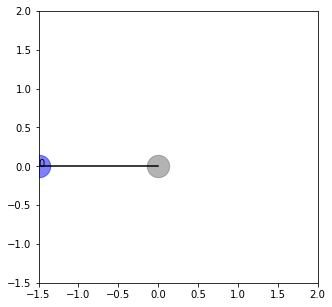

====6th kernel info====
6th-p_support:
torch.Size([1, 2])


6th-x_support:
tensor([[0.2683, 0.3414, 0.3581, 0.3997, 0.6885, 0.7681, 0.7947, 0.9605, 0.7612,
         0.5292, 0.3711, 0.0922, 0.7564, 0.1872, 0.1689, 0.5019, 0.5836, 0.6703,
         0.3716, 0.3105, 0.1444, 0.5704, 0.4755, 0.3554, 0.2793, 0.0489, 0.1833,
         0.7198, 0.0283, 0.2717, 0.4888, 0.1333, 0.1189, 0.9355, 0.2144, 0.4328,
         0.1252, 0.3759, 0.5776, 0.3622, 0.4360, 0.0590, 0.8390, 0.0741, 0.3744,
         0.1948, 0.8314, 0.2539, 0.8155, 0.7781, 0.3675, 0.0773, 0.2052, 0.3358,
         0.2563, 0.3642, 0.7713, 0.8701, 0.9398, 0.7876]])


6th-x_center:
tensor([[0.5198, 0.4059, 0.9009, 0.0788, 0.1614, 0.5671, 0.1475, 0.6576, 0.8695,
         0.5883, 0.7329, 0.9877, 0.5010, 0.2543, 0.7453, 0.3614, 0.9895, 0.9150,
         0.4143, 0.8612, 0.9905, 0.3329, 0.9263, 0.1743, 0.9393, 0.4229, 0.8568,
         0.9823, 0.1201, 0.9788, 0.7924, 0.3320, 0.9091, 0.1756, 0.9679, 0.4713,
         0.8593, 0.9879, 0.8563, 0.3353,

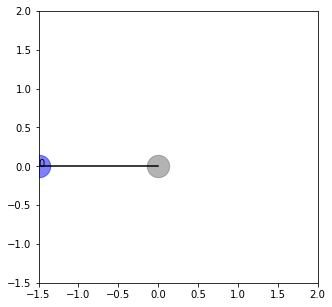

====7th kernel info====
7th-p_support:
torch.Size([1, 2])


7th-x_support:
tensor([[0.2164, 0.7925, 0.7326, 0.6790, 0.8857, 0.1701, 0.5460, 0.4960, 0.1427,
         0.7518, 0.2063, 0.5445, 0.6094, 0.3543, 0.6722, 0.6148, 0.1171, 0.1253,
         0.8600, 0.0837, 0.6870, 0.7624, 0.2133, 0.2910, 0.8411, 0.2639, 0.4222,
         0.1128, 0.1624, 0.4054, 0.0023, 0.8185, 0.6747, 0.4722, 0.2138, 0.4514,
         0.6416, 0.0522, 0.6587, 0.4998, 0.3359, 0.4282, 0.4338, 0.6237, 0.5071,
         0.9148, 0.2761, 0.6771, 0.8894, 0.3189, 0.6290, 0.8230, 0.9858, 0.5632,
         0.0178, 0.8338, 0.5630, 0.2830, 0.9063, 0.3025]])


7th-x_center:
tensor([[0.0018, 0.8623, 0.9272, 0.8315, 0.0928, 0.6474, 0.4294, 0.4877, 0.5977,
         0.3090, 0.7659, 0.4869, 0.7361, 0.4737, 0.7358, 0.2757, 0.9001, 0.6589,
         0.5879, 0.2603, 0.8110, 0.7087, 0.0389, 0.7565, 0.6489, 0.9337, 0.6090,
         0.7361, 0.9895, 0.7767, 0.1497, 0.9687, 0.4334, 0.0787, 0.6598, 0.2542,
         0.0287, 0.6118, 0.0926, 0.9752,

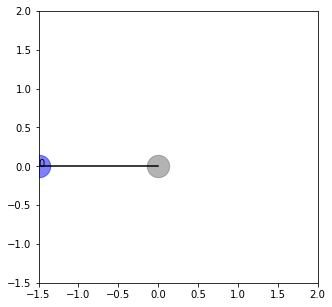

====8th kernel info====
8th-p_support:
torch.Size([1, 2])


8th-x_support:
tensor([[0.7280, 0.0145, 0.3085, 0.0177, 0.2545, 0.8512, 0.2114, 0.4350, 0.3302,
         0.4728, 0.2384, 0.9059, 0.3199, 0.9791, 0.9538, 0.1350, 0.4296, 0.7865,
         0.6504, 0.9911, 0.9367, 0.5625, 0.8195, 0.1329, 0.5538, 0.0230, 0.9648,
         0.1621, 0.9549, 0.1536, 0.0347, 0.4044, 0.9224, 0.3728, 0.3102, 0.5326,
         0.2156, 0.7739, 0.6761, 0.9735, 0.0247, 0.8777, 0.2838, 0.7160, 0.0639,
         0.2435, 0.0339, 0.0419, 0.1774, 0.0033, 0.6044, 0.7911, 0.7436, 0.6555,
         0.1496, 0.6990, 0.4549, 0.3231, 0.8940, 0.7321]])


8th-x_center:
tensor([[0.3880, 0.8126, 0.0768, 0.5342, 0.6823, 0.8021, 0.4996, 0.9117, 0.4143,
         0.1171, 0.4459, 0.9549, 0.7881, 0.3588, 0.0508, 0.3352, 0.5707, 0.9690,
         0.6212, 0.1354, 0.9960, 0.6570, 0.6127, 0.1799, 0.7702, 0.5407, 0.3119,
         0.4033, 0.3525, 0.3153, 0.8753, 0.8533, 0.0985, 0.0643, 0.3149, 0.5522,
         0.7179, 0.8749, 0.0098, 0.5034,

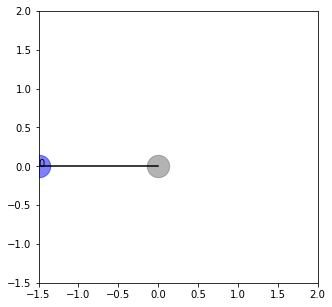

====9th kernel info====
9th-p_support:
torch.Size([1, 2])


9th-x_support:
tensor([[0.0115, 0.6361, 0.9820, 0.3360, 0.9162, 0.2630, 0.2948, 0.3458, 0.1153,
         0.6820, 0.5269, 0.7238, 0.9401, 0.2686, 0.2964, 0.9117, 0.7994, 0.0726,
         0.1196, 0.5686, 0.8044, 0.4892, 0.0497, 0.5289, 0.1109, 0.6068, 0.3465,
         0.5885, 0.6357, 0.1910, 0.8411, 0.2817, 0.9695, 0.9460, 0.9799, 0.1455,
         0.6653, 0.6651, 0.8619, 0.6988, 0.0645, 0.7052, 0.8034, 0.8743, 0.8225,
         0.6622, 0.9106, 0.0500, 0.3338, 0.1393, 0.1588, 0.8280, 0.7395, 0.8382,
         0.9789, 0.6074, 0.6879, 0.5236, 0.8869, 0.0618]])


9th-x_center:
tensor([[0.2229, 0.5661, 0.4374, 0.5483, 0.9300, 0.8795, 0.8412, 0.7971, 0.5544,
         0.6801, 0.8405, 0.0963, 0.7899, 0.1041, 0.4520, 0.8790, 0.0144, 0.5783,
         0.2957, 0.4087, 0.5817, 0.5436, 0.0810, 0.1368, 0.3403, 0.0017, 0.1297,
         0.7090, 0.9521, 0.6075, 0.5744, 0.6061, 0.2351, 0.1201, 0.3631, 0.5983,
         0.7212, 0.2684, 0.4384, 0.8879,

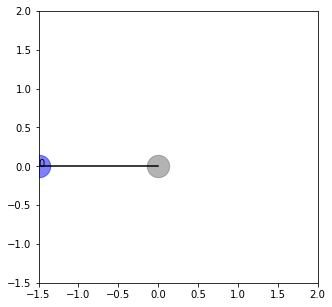

====10th kernel info====
10th-p_support:
torch.Size([1, 2])


10th-x_support:
tensor([[0.4906, 0.6321, 0.3404, 0.7701, 0.9869, 0.2609, 0.1368, 0.2000, 0.4056,
         0.2213, 0.3266, 0.7028, 0.4150, 0.6083, 0.0757, 0.9375, 0.6948, 0.3288,
         0.9914, 0.3314, 0.1208, 0.1596, 0.3441, 0.4728, 0.5502, 0.3537, 0.2032,
         0.2093, 0.2029, 0.6346, 0.0257, 0.4980, 0.1189, 0.7086, 0.3810, 0.7407,
         0.3922, 0.7176, 0.2328, 0.0952, 0.5465, 0.0952, 0.9691, 0.0578, 0.6811,
         0.3712, 0.1201, 0.3007, 0.0138, 0.2855, 0.3208, 0.4423, 0.4140, 0.6602,
         0.4827, 0.0306, 0.6694, 0.5508, 0.6351, 0.9961]])


10th-x_center:
tensor([[0.7658, 0.5340, 0.4579, 0.1144, 0.3392, 0.0375, 0.3190, 0.0830, 0.3915,
         0.2130, 0.7830, 0.3102, 0.4473, 0.1840, 0.4048, 0.0395, 0.3570, 0.1071,
         0.9726, 0.6663, 0.1394, 0.8682, 0.2715, 0.1229, 0.8555, 0.9756, 0.8494,
         0.8737, 0.8118, 0.4427, 0.8895, 0.1305, 0.3273, 0.2778, 0.6628, 0.9917,
         0.5395, 0.0364, 0.5682, 0.0

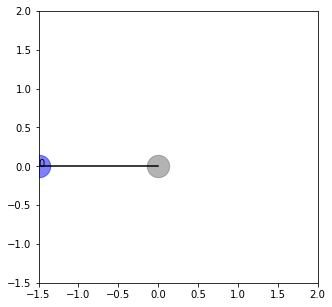

====11th kernel info====
11th-p_support:
torch.Size([1, 2])


11th-x_support:
tensor([[7.4367e-04, 2.3780e-01, 3.2107e-01, 9.4667e-01, 7.2908e-01, 8.5897e-01,
         4.1090e-02, 6.8143e-01, 7.2820e-01, 3.4236e-01, 1.1381e-01, 3.4461e-01,
         6.0556e-01, 3.9714e-01, 5.7092e-01, 9.1114e-01, 4.3982e-01, 8.9057e-01,
         6.5527e-01, 9.2117e-01, 8.5644e-01, 6.9880e-01, 4.8949e-01, 9.9098e-01,
         6.7553e-01, 6.4725e-01, 8.7578e-01, 2.9722e-02, 5.5891e-01, 7.0288e-01,
         9.4285e-01, 3.4556e-01, 9.8992e-01, 2.2501e-01, 5.5195e-01, 5.0029e-01,
         2.6492e-01, 7.3333e-01, 8.0978e-01, 9.4386e-01, 2.5880e-01, 1.7458e-01,
         7.6769e-01, 7.4951e-01, 4.9412e-01, 1.3560e-01, 8.9421e-01, 6.1424e-01,
         9.2417e-01, 7.7490e-01, 6.6189e-01, 9.6070e-01, 5.0754e-01, 8.6876e-01,
         7.3835e-01, 5.6634e-01, 4.4285e-01, 7.0197e-01, 9.6155e-02, 7.3494e-01]])


11th-x_center:
tensor([[0.5408, 0.0350, 0.7326, 0.2166, 0.0751, 0.1138, 0.7151, 0.1082, 0.5008,
         0.7

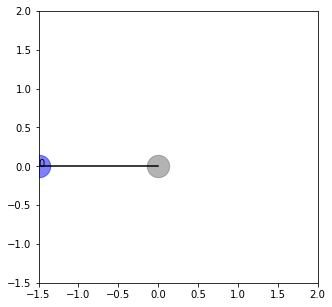

====12th kernel info====
12th-p_support:
torch.Size([1, 2])


12th-x_support:
tensor([[0.1491, 0.7788, 0.6715, 0.5240, 0.4101, 0.1349, 0.0324, 0.2883, 0.0077,
         0.6848, 0.1707, 0.5960, 0.4462, 0.5565, 0.9040, 0.5567, 0.6278, 0.4151,
         0.5123, 0.0345, 0.7178, 0.8451, 0.8984, 0.7868, 0.6192, 0.1473, 0.7863,
         0.0723, 0.7005, 0.0941, 0.9566, 0.3496, 0.5032, 0.3449, 0.2648, 0.6320,
         0.9956, 0.9659, 0.9592, 0.5452, 0.5266, 0.7508, 0.3358, 0.9141, 0.8152,
         0.2332, 0.1471, 0.6481, 0.8588, 0.2221, 0.5505, 0.0336, 0.3766, 0.6272,
         0.1752, 0.3420, 0.7392, 0.4507, 0.3901, 0.2806]])


12th-x_center:
tensor([[0.4388, 0.5900, 0.9993, 0.1127, 0.4322, 0.3243, 0.9066, 0.1730, 0.4625,
         0.1582, 0.4809, 0.4642, 0.0842, 0.4248, 0.6755, 0.3920, 0.0696, 0.8202,
         0.9969, 0.7406, 0.6971, 0.3839, 0.1733, 0.0404, 0.8885, 0.5965, 0.3370,
         0.2662, 0.1960, 0.3674, 0.8796, 0.8847, 0.1506, 0.2972, 0.5707, 0.7916,
         0.2396, 0.6281, 0.8706, 0.6

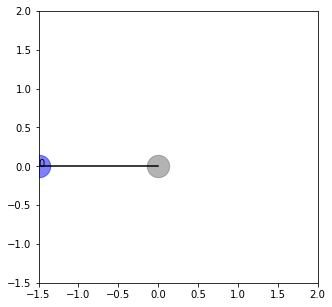

====13th kernel info====
13th-p_support:
torch.Size([1, 2])


13th-x_support:
tensor([[0.6534, 0.0124, 0.1992, 0.9448, 0.5602, 0.3222, 0.5087, 0.5825, 0.2302,
         0.5875, 0.0296, 0.3067, 0.8631, 0.9628, 0.8684, 0.1766, 0.8488, 0.6978,
         0.5289, 0.9345, 0.6693, 0.7976, 0.0147, 0.7387, 0.6005, 0.3984, 0.9611,
         0.8345, 0.9185, 0.2788, 0.8387, 0.9976, 0.1984, 0.9791, 0.5145, 0.7200,
         0.2514, 0.9007, 0.0026, 0.4062, 0.6764, 0.5366, 0.2382, 0.0946, 0.0944,
         0.5630, 0.3791, 0.5938, 0.0945, 0.1987, 0.5486, 0.9804, 0.4895, 0.6870,
         0.5620, 0.9773, 0.1795, 0.4355, 0.0633, 0.1360]])


13th-x_center:
tensor([[0.1133, 0.6971, 0.7522, 0.5039, 0.3122, 0.5908, 0.5361, 0.4718, 0.0107,
         0.0580, 0.4514, 0.3043, 0.1296, 0.0514, 0.6754, 0.2053, 0.1230, 0.2749,
         0.2953, 0.2825, 0.0519, 0.3903, 0.3917, 0.3846, 0.0492, 0.3078, 0.8659,
         0.6242, 0.5406, 0.5264, 0.7371, 0.5853, 0.8613, 0.1756, 0.0938, 0.4478,
         0.0276, 0.5140, 0.8846, 0.7

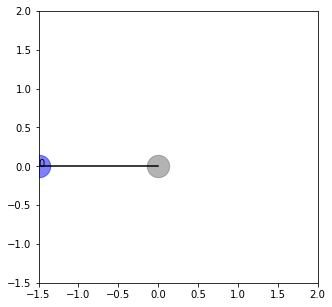

====14th kernel info====
14th-p_support:
torch.Size([1, 2])


14th-x_support:
tensor([[0.9995, 0.9879, 0.8887, 0.2196, 0.0192, 0.1306, 0.2148, 0.9328, 0.9246,
         0.9138, 0.2863, 0.1918, 0.9199, 0.3812, 0.7912, 0.7053, 0.2828, 0.5595,
         0.8107, 0.9694, 0.4235, 0.6554, 0.2016, 0.1412, 0.3299, 0.4335, 0.9222,
         0.5779, 0.8359, 0.1981, 0.3493, 0.3296, 0.8139, 0.1335, 0.4284, 0.4752,
         0.9539, 0.0558, 0.4379, 0.8906, 0.4298, 0.0681, 0.1777, 0.0216, 0.2201,
         0.4936, 0.9856, 0.2419, 0.9573, 0.6227, 0.0989, 0.2604, 0.1214, 0.1044,
         0.7747, 0.3124, 0.3759, 0.7617, 0.2215, 0.4962]])


14th-x_center:
tensor([[0.1349, 0.3264, 0.7962, 0.5548, 0.0542, 0.5196, 0.4953, 0.8240, 0.4544,
         0.3203, 0.7231, 0.5442, 0.5585, 0.9692, 0.1025, 0.3437, 0.3389, 0.5544,
         0.1447, 0.6076, 0.9897, 0.4145, 0.7338, 0.4575, 0.8907, 0.4676, 0.8680,
         0.5872, 0.0935, 0.4750, 0.4385, 0.3079, 0.7681, 0.3736, 0.6838, 0.8719,
         0.9784, 0.2624, 0.2712, 0.6

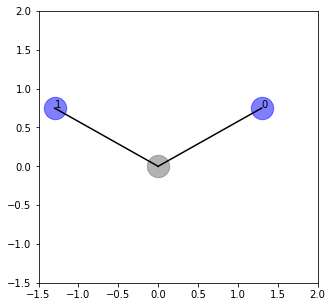

====0th kernel info====
0th-p_support:
torch.Size([2, 2])


0th-x_support:
tensor([[0.5129, 0.2543, 0.0555, 0.4955, 0.1645, 0.0358, 0.7260, 0.1394, 0.4960,
         0.6671, 0.2132, 0.8662, 0.7228, 0.9976, 0.0594, 0.9323, 0.3145, 0.1079,
         0.2228, 0.0821, 0.7722, 0.2374, 0.6035, 0.8927, 0.3568, 0.4576, 0.2788,
         0.0777, 0.6116, 0.9113, 0.4432, 0.6775, 0.1202, 0.6765, 0.7653, 0.3388,
         0.8334, 0.2035, 0.2724, 0.5109, 0.7759, 0.5155, 0.2262, 0.0754, 0.0513,
         0.3648, 0.3833, 0.8578, 0.5467, 0.2664, 0.8980, 0.3133, 0.0034, 0.3255,
         0.4081, 0.6469, 0.8832, 0.2452, 0.4466, 0.8491],
        [0.9121, 0.8227, 0.7040, 0.5623, 0.9805, 0.4948, 0.9521, 0.0392, 0.1831,
         0.1809, 0.1079, 0.4915, 0.0944, 0.3184, 0.1997, 0.0761, 0.9018, 0.6482,
         0.5054, 0.3886, 0.8449, 0.0574, 0.1450, 0.9350, 0.3442, 0.1757, 0.5538,
         0.0701, 0.9691, 0.9853, 0.8973, 0.8670, 0.8297, 0.1063, 0.3065, 0.6905,
         0.6142, 0.2116, 0.6595, 0.8335, 0.5033, 0.0820, 

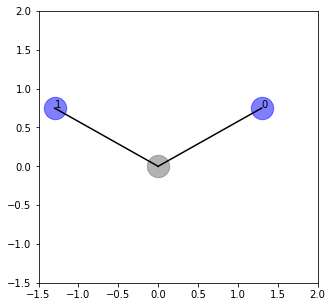

====1th kernel info====
1th-p_support:
torch.Size([2, 2])


1th-x_support:
tensor([[0.2109, 0.9073, 0.0857, 0.5210, 0.1826, 0.9466, 0.6896, 0.6724, 0.7901,
         0.1695, 0.3994, 0.1684, 0.9159, 0.1667, 0.7835, 0.9648, 0.6174, 0.2312,
         0.4065, 0.9267, 0.8770, 0.6080, 0.1450, 0.8408, 0.5343, 0.4522, 0.6587,
         0.9056, 0.0342, 0.1178, 0.7804, 0.4165, 0.0906, 0.1021, 0.3753, 0.0238,
         0.9654, 0.6630, 0.5501, 0.6873, 0.8050, 0.6313, 0.8801, 0.5291, 0.6553,
         0.8235, 0.7378, 0.6858, 0.2768, 0.2506, 0.6097, 0.1853, 0.8842, 0.9709,
         0.5607, 0.8063, 0.0863, 0.5348, 0.9927, 0.2082],
        [0.1170, 0.5797, 0.9285, 0.9765, 0.2293, 0.3093, 0.5728, 0.1405, 0.7071,
         0.3276, 0.1209, 0.2592, 0.7687, 0.7560, 0.0123, 0.3362, 0.9305, 0.8203,
         0.9351, 0.8988, 0.1790, 0.2703, 0.8189, 0.9635, 0.1089, 0.5975, 0.2422,
         0.2595, 0.6886, 0.3073, 0.7407, 0.9383, 0.9281, 0.8193, 0.1663, 0.1807,
         0.4531, 0.0558, 0.2399, 0.0661, 0.3506, 0.5021, 

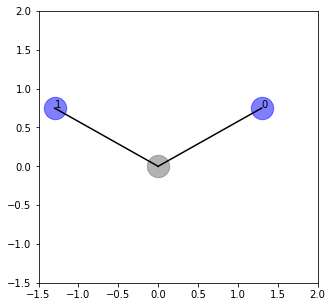

====2th kernel info====
2th-p_support:
torch.Size([2, 2])


2th-x_support:
tensor([[0.5129, 0.9699, 0.0762, 0.5450, 0.3290, 0.0100, 0.1516, 0.9570, 0.2707,
         0.0308, 0.7013, 0.1938, 0.3102, 0.0563, 0.4978, 0.2499, 0.8255, 0.4157,
         0.4854, 0.2039, 0.1597, 0.4624, 0.1876, 0.6263, 0.2653, 0.8155, 0.6471,
         0.2925, 0.4711, 0.4151, 0.9117, 0.6205, 0.6331, 0.8181, 0.7782, 0.5274,
         0.4347, 0.8120, 0.1027, 0.3633, 0.2426, 0.4187, 0.4888, 0.9738, 0.3712,
         0.4532, 0.7253, 0.6986, 0.3277, 0.5545, 0.6905, 0.7168, 0.0288, 0.8374,
         0.4522, 0.1195, 0.0861, 0.6736, 0.7921, 0.1939],
        [0.6974, 0.5332, 0.9828, 0.4537, 0.1734, 0.9463, 0.9010, 0.2197, 0.9942,
         0.1462, 0.8269, 0.6730, 0.2010, 0.5042, 0.8404, 0.0294, 0.4941, 0.4204,
         0.9389, 0.2769, 0.0950, 0.9530, 0.8114, 0.6602, 0.5497, 0.3700, 0.1214,
         0.0336, 0.9495, 0.8246, 0.4073, 0.8977, 0.9313, 0.7310, 0.7899, 0.1075,
         0.4294, 0.8995, 0.3353, 0.9549, 0.2863, 0.5458, 

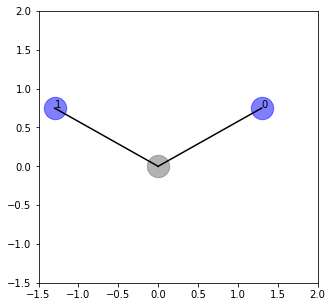

====3th kernel info====
3th-p_support:
torch.Size([2, 2])


3th-x_support:
tensor([[0.2979, 0.8410, 0.0231, 0.4853, 0.7018, 0.7956, 0.4748, 0.9802, 0.9374,
         0.0494, 0.2292, 0.5661, 0.7115, 0.7112, 0.3508, 0.1425, 0.0492, 0.4747,
         0.0953, 0.4708, 0.8842, 0.2007, 0.5881, 0.7198, 0.7399, 0.2158, 0.8943,
         0.1235, 0.6259, 0.7363, 0.2772, 0.5971, 0.1845, 0.2273, 0.4369, 0.2265,
         0.4964, 0.9787, 0.4376, 0.1088, 0.0038, 0.8043, 0.2461, 0.7220, 0.2033,
         0.1555, 0.2856, 0.5274, 0.8535, 0.1012, 0.7438, 0.2623, 0.4086, 0.1172,
         0.8702, 0.1574, 0.2518, 0.8130, 0.2719, 0.1056],
        [0.7439, 0.8494, 0.2194, 0.1766, 0.8843, 0.2570, 0.4521, 0.1213, 0.4898,
         0.7348, 0.0717, 0.3774, 0.8026, 0.6441, 0.4517, 0.2449, 0.9159, 0.3923,
         0.4082, 0.9493, 0.4472, 0.6209, 0.5932, 0.0800, 0.0841, 0.2858, 0.8869,
         0.9292, 0.5775, 0.4311, 0.3918, 0.7700, 0.0582, 0.4572, 0.5747, 0.1463,
         0.3231, 0.8051, 0.4884, 0.9433, 0.3120, 0.9202, 

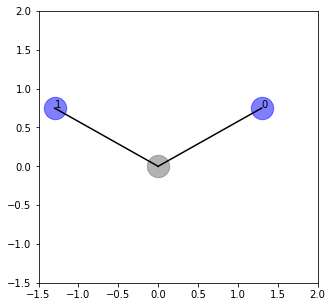

====4th kernel info====
4th-p_support:
torch.Size([2, 2])


4th-x_support:
tensor([[0.8948, 0.3954, 0.7365, 0.4243, 0.8664, 0.3250, 0.6116, 0.4157, 0.7307,
         0.7552, 0.4163, 0.3553, 0.5793, 0.2908, 0.1033, 0.9132, 0.1467, 0.0652,
         0.9109, 0.8649, 0.4023, 0.8150, 0.4226, 0.5794, 0.1723, 0.4665, 0.5633,
         0.9436, 0.0138, 0.0204, 0.8443, 0.3218, 0.0435, 0.8803, 0.2353, 0.4884,
         0.5149, 0.6093, 0.7489, 0.9116, 0.1030, 0.9022, 0.0997, 0.6340, 0.3043,
         0.0355, 0.3670, 0.8816, 0.6948, 0.5865, 0.0849, 0.2432, 0.3141, 0.9764,
         0.6085, 0.7306, 0.5112, 0.5211, 0.0073, 0.8929],
        [0.8597, 0.8049, 0.8794, 0.8087, 0.2089, 0.5555, 0.1430, 0.9748, 0.2127,
         0.8397, 0.0054, 0.3937, 0.4451, 0.3199, 0.1253, 0.9581, 0.7576, 0.4480,
         0.0485, 0.8684, 0.1379, 0.2034, 0.3916, 0.3674, 0.5841, 0.6590, 0.9034,
         0.6194, 0.6456, 0.1353, 0.9678, 0.8480, 0.5389, 0.6857, 0.7267, 0.0745,
         0.3007, 0.2810, 0.8506, 0.3321, 0.9001, 0.5837, 

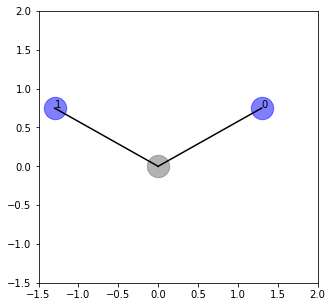

====5th kernel info====
5th-p_support:
torch.Size([2, 2])


5th-x_support:
tensor([[0.5135, 0.0577, 0.5127, 0.7827, 0.1964, 0.4528, 0.3947, 0.3135, 0.5026,
         0.0241, 0.0897, 0.8408, 0.6329, 0.0124, 0.7451, 0.6872, 0.0812, 0.5533,
         0.0236, 0.5914, 0.0573, 0.9820, 0.4595, 0.6778, 0.2458, 0.0891, 0.5957,
         0.2083, 0.1758, 0.5299, 0.2606, 0.3903, 0.2329, 0.5818, 0.8792, 0.7868,
         0.1608, 0.7501, 0.8204, 0.8878, 0.8625, 0.1478, 0.0896, 0.8639, 0.0186,
         0.6941, 0.7129, 0.8709, 0.0550, 0.7142, 0.3426, 0.2026, 0.7065, 0.8050,
         0.0017, 0.5817, 0.4247, 0.9135, 0.6896, 0.5481],
        [0.1796, 0.0159, 0.6808, 0.9719, 0.9054, 0.8505, 0.9542, 0.5083, 0.4534,
         0.9862, 0.3785, 0.3432, 0.7937, 0.7303, 0.5053, 0.7149, 0.4490, 0.1266,
         0.2972, 0.2691, 0.9989, 0.3439, 0.5960, 0.9142, 0.6709, 0.1707, 0.6329,
         0.7468, 0.2964, 0.9692, 0.4699, 0.2283, 0.8441, 0.5028, 0.5054, 0.8664,
         0.3901, 0.9631, 0.6708, 0.1699, 0.8938, 0.6978, 

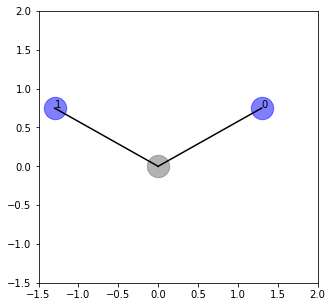

====6th kernel info====
6th-p_support:
torch.Size([2, 2])


6th-x_support:
tensor([[0.0662, 0.2216, 0.8501, 0.7222, 0.7197, 0.9999, 0.2795, 0.7256, 0.3156,
         0.9028, 0.4176, 0.1188, 0.0553, 0.7255, 0.2836, 0.7314, 0.9969, 0.7887,
         0.8596, 0.0971, 0.3630, 0.1189, 0.8004, 0.7292, 0.0256, 0.9330, 0.4619,
         0.8522, 0.6184, 0.9569, 0.4438, 0.8908, 0.5264, 0.0457, 0.5755, 0.6600,
         0.4292, 0.4881, 0.6255, 0.3981, 0.1419, 0.5728, 0.5655, 0.2488, 0.5442,
         0.5499, 0.9173, 0.8669, 0.3332, 0.1083, 0.2149, 0.0573, 0.1152, 0.6451,
         0.6048, 0.6485, 0.3018, 0.3046, 0.3159, 0.7571],
        [0.5148, 0.1916, 0.7534, 0.7892, 0.0659, 0.8454, 0.7446, 0.5901, 0.9285,
         0.6396, 0.8152, 0.4161, 0.7883, 0.0907, 0.0861, 0.2042, 0.4281, 0.2373,
         0.8091, 0.0628, 0.7507, 0.2493, 0.3684, 0.6862, 0.7470, 0.3490, 0.9220,
         0.2977, 0.6583, 0.5749, 0.7226, 0.1879, 0.5807, 0.2668, 0.8927, 0.9985,
         0.7647, 0.1001, 0.2795, 0.1782, 0.2858, 0.1874, 

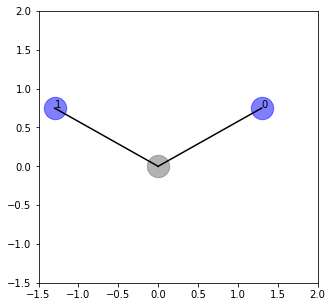

====7th kernel info====
7th-p_support:
torch.Size([2, 2])


7th-x_support:
tensor([[0.2587, 0.3223, 0.6731, 0.0250, 0.1719, 0.2345, 0.3735, 0.2639, 0.9895,
         0.6750, 0.6979, 0.0651, 0.0347, 0.6553, 0.2843, 0.8662, 0.3247, 0.9402,
         0.1644, 0.7570, 0.5989, 0.3331, 0.5936, 0.8481, 0.0720, 0.5297, 0.7037,
         0.4641, 0.3367, 0.6329, 0.2070, 0.5101, 0.7579, 0.3099, 0.8308, 0.2839,
         0.4382, 0.2767, 0.6218, 0.6586, 0.4668, 0.3331, 0.3506, 0.0900, 0.7934,
         0.5194, 0.0865, 0.0431, 0.7316, 0.7613, 0.6469, 0.9884, 0.4982, 0.3537,
         0.7951, 0.1538, 0.1335, 0.7899, 0.1216, 0.1185],
        [0.4921, 0.2793, 0.7319, 0.6989, 0.0487, 0.9517, 0.1808, 0.2235, 0.2361,
         0.5620, 0.1074, 0.2958, 0.4525, 0.4850, 0.5645, 0.9844, 0.8222, 0.4536,
         0.5083, 0.4943, 0.1098, 0.8620, 0.2717, 0.1165, 0.5973, 0.1091, 0.4825,
         0.6455, 0.5144, 0.9374, 0.0987, 0.2632, 0.6690, 0.7778, 0.2738, 0.3190,
         0.5630, 0.0832, 0.4410, 0.1608, 0.2604, 0.5814, 

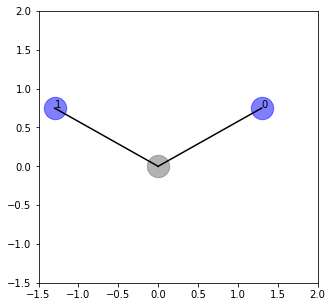

====8th kernel info====
8th-p_support:
torch.Size([2, 2])


8th-x_support:
tensor([[0.8938, 0.0041, 0.9021, 0.7819, 0.2916, 0.8202, 0.2463, 0.5428, 0.3608,
         0.0288, 0.0406, 0.5394, 0.6694, 0.8623, 0.0460, 0.6663, 0.0424, 0.3506,
         0.6217, 0.1463, 0.9681, 0.3527, 0.7079, 0.1618, 0.6135, 0.3727, 0.6828,
         0.9041, 0.0235, 0.6630, 0.4936, 0.0295, 0.6641, 0.5847, 0.3836, 0.5076,
         0.9491, 0.4981, 0.6644, 0.2923, 0.4627, 0.7831, 0.7359, 0.2804, 0.1692,
         0.1932, 0.0593, 0.8016, 0.2757, 0.2305, 0.6232, 0.2690, 0.4613, 0.4694,
         0.1636, 0.0344, 0.5805, 0.8947, 0.9408, 0.0700],
        [0.2795, 0.4073, 0.7574, 0.5264, 0.6437, 0.6679, 0.4657, 0.4118, 0.4133,
         0.6812, 0.1474, 0.4857, 0.5994, 0.7701, 0.3257, 0.4568, 0.1448, 0.4519,
         0.6520, 0.3374, 0.8295, 0.8016, 0.4752, 0.2174, 0.9240, 0.8807, 0.2851,
         0.5856, 0.3280, 0.8016, 0.2294, 0.1830, 0.2612, 0.6654, 0.1798, 0.9701,
         0.3912, 0.7579, 0.2259, 0.2398, 0.5291, 0.7060, 

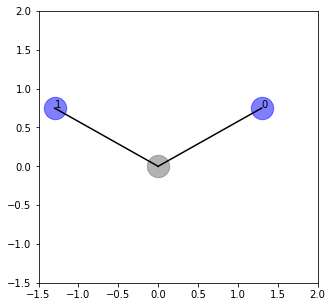

====9th kernel info====
9th-p_support:
torch.Size([2, 2])


9th-x_support:
tensor([[0.8671, 0.8311, 0.4381, 0.2392, 0.9592, 0.2783, 0.3053, 0.8072, 0.8185,
         0.0430, 0.1694, 0.3341, 0.3621, 0.7739, 0.0349, 0.2667, 0.8690, 0.6314,
         0.7253, 0.8401, 0.7111, 0.8761, 0.4785, 0.9490, 0.2326, 0.1566, 0.6755,
         0.7098, 0.0665, 0.6633, 0.9206, 0.8072, 0.4903, 0.1820, 0.3664, 0.5040,
         0.1575, 0.7961, 0.6507, 0.1238, 0.0191, 0.9092, 0.7412, 0.6764, 0.2155,
         0.2871, 0.5879, 0.3191, 0.5474, 0.6669, 0.4356, 0.3052, 0.0816, 0.5483,
         0.2565, 0.2377, 0.1837, 0.3298, 0.1449, 0.8775],
        [0.2810, 0.9599, 0.6571, 0.5826, 0.2337, 0.4969, 0.5166, 0.1455, 0.5110,
         0.0840, 0.6597, 0.1276, 0.3099, 0.9889, 0.9024, 0.6785, 0.8688, 0.8108,
         0.3076, 0.7797, 0.1735, 0.0991, 0.1539, 0.1041, 0.4729, 0.7159, 0.3309,
         0.1160, 0.6947, 0.1258, 0.9438, 0.7777, 0.8021, 0.0637, 0.1885, 0.3787,
         0.2903, 0.0234, 0.6724, 0.5182, 0.6109, 0.6922, 

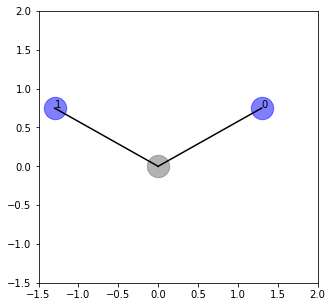

====10th kernel info====
10th-p_support:
torch.Size([2, 2])


10th-x_support:
tensor([[3.6536e-01, 5.1957e-01, 7.2893e-01, 5.8314e-01, 5.2445e-01, 6.5238e-01,
         3.0623e-01, 8.8960e-01, 7.3436e-01, 1.9066e-01, 1.4527e-01, 9.2759e-01,
         7.1309e-01, 4.3244e-01, 9.8197e-01, 7.5726e-04, 3.0721e-01, 2.5686e-01,
         7.8648e-01, 4.2515e-01, 2.7309e-01, 8.9036e-03, 7.1457e-01, 6.8703e-01,
         3.1779e-01, 6.3901e-01, 6.0657e-01, 1.6498e-01, 6.2079e-01, 2.2245e-01,
         6.8999e-01, 2.4554e-02, 4.2200e-02, 6.1846e-01, 3.6984e-01, 3.8194e-01,
         4.7156e-01, 1.9726e-01, 6.9380e-01, 2.2910e-01, 9.4681e-01, 5.6386e-01,
         9.6305e-01, 6.1912e-01, 3.3367e-02, 7.8694e-01, 3.3308e-01, 6.9008e-01,
         3.4190e-01, 4.7969e-01, 8.3509e-01, 9.7129e-01, 6.4874e-01, 8.0123e-01,
         4.7358e-01, 9.2611e-01, 9.5320e-01, 4.9662e-01, 1.9162e-01, 9.3490e-01],
        [7.6378e-01, 5.8359e-01, 5.0313e-01, 1.0275e-01, 3.4551e-01, 8.1882e-01,
         8.3231e-01, 9.1994e-0

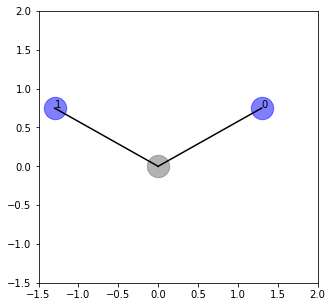

====11th kernel info====
11th-p_support:
torch.Size([2, 2])


11th-x_support:
tensor([[0.8833, 0.5917, 0.7028, 0.2907, 0.7595, 0.2244, 0.7507, 0.7405, 0.9545,
         0.9285, 0.6152, 0.9146, 0.4345, 0.9041, 0.1791, 0.8456, 0.6382, 0.8134,
         0.4325, 0.1313, 0.7195, 0.6312, 0.6308, 0.3267, 0.8009, 0.6195, 0.6275,
         0.9287, 0.9602, 0.0434, 0.2499, 0.4725, 0.0390, 0.0097, 0.4083, 0.8379,
         0.4756, 0.8304, 0.4250, 0.7711, 0.2198, 0.8721, 0.9360, 0.2895, 0.6257,
         0.6805, 0.1758, 0.1829, 0.7144, 0.5469, 0.6863, 0.0325, 0.2652, 0.5012,
         0.1009, 0.3844, 0.8138, 0.6529, 0.6125, 0.5754],
        [0.1912, 0.1781, 0.6236, 0.1177, 0.7399, 0.8166, 0.2907, 0.5738, 0.0133,
         0.1741, 0.2645, 0.3094, 0.0672, 0.4277, 0.4734, 0.0817, 0.7310, 0.9859,
         0.3262, 0.7730, 0.6930, 0.3505, 0.7759, 0.4550, 0.7247, 0.2318, 0.6016,
         0.9575, 0.9362, 0.0785, 0.3598, 0.3028, 0.2465, 0.9592, 0.0875, 0.8669,
         0.5160, 0.4221, 0.8250, 0.3228, 0.4988, 0.370

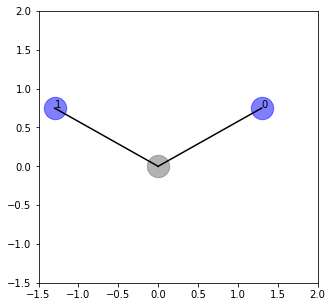

====12th kernel info====
12th-p_support:
torch.Size([2, 2])


12th-x_support:
tensor([[0.1206, 0.6811, 0.5800, 0.8137, 0.0303, 0.6654, 0.4896, 0.2691, 0.9151,
         0.7847, 0.9820, 0.6690, 0.1792, 0.9391, 0.9837, 0.7893, 0.9366, 0.0207,
         0.7790, 0.1217, 0.8734, 0.2661, 0.9789, 0.2096, 0.8323, 0.9191, 0.8094,
         0.2363, 0.4092, 0.0568, 0.8300, 0.0398, 0.9157, 0.9851, 0.8311, 0.8263,
         0.5775, 0.3309, 0.1754, 0.7153, 0.7869, 0.5399, 0.3926, 0.2743, 0.7782,
         0.1327, 0.9641, 0.0697, 0.0788, 0.5062, 0.6997, 0.5316, 0.5385, 0.2871,
         0.7638, 0.7943, 0.5416, 0.9896, 0.5522, 0.2189],
        [0.9473, 0.9998, 0.0068, 0.0637, 0.1624, 0.9028, 0.2207, 0.6382, 0.4017,
         0.5535, 0.0771, 0.4358, 0.2823, 0.7160, 0.4251, 0.8014, 0.5171, 0.1277,
         0.8488, 0.3433, 0.6083, 0.7707, 0.6923, 0.5809, 0.9733, 0.3292, 0.2842,
         0.0330, 0.7153, 0.4658, 0.1786, 0.6697, 0.2376, 0.9463, 0.9611, 0.8485,
         0.2744, 0.5441, 0.7334, 0.2151, 0.2892, 0.515

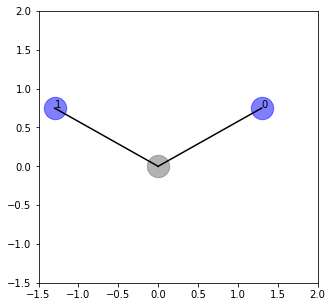

====13th kernel info====
13th-p_support:
torch.Size([2, 2])


13th-x_support:
tensor([[9.0945e-02, 1.1418e-01, 6.5929e-01, 9.5833e-01, 8.5411e-04, 4.0649e-01,
         7.4530e-01, 2.8524e-01, 4.3353e-01, 1.5107e-01, 5.5345e-02, 9.7894e-01,
         2.6819e-01, 3.3348e-01, 8.8814e-01, 4.3104e-02, 6.2601e-01, 6.0889e-01,
         9.4591e-01, 4.4106e-01, 3.4760e-02, 1.0583e-01, 5.1101e-01, 8.5507e-01,
         5.0674e-01, 9.7037e-01, 6.5348e-01, 4.1756e-01, 2.2102e-01, 4.3501e-01,
         5.3027e-01, 6.0650e-01, 1.1328e-01, 3.5284e-01, 1.7776e-01, 5.0234e-01,
         3.5017e-01, 2.0535e-01, 8.2959e-01, 2.0339e-01, 2.1240e-01, 2.6392e-01,
         1.3391e-01, 3.7423e-01, 6.2346e-01, 8.9750e-01, 2.6296e-01, 9.4963e-01,
         1.8789e-01, 8.3897e-01, 2.2386e-01, 9.3101e-01, 3.4879e-01, 1.6727e-02,
         3.7470e-02, 2.6461e-01, 9.5969e-01, 1.8579e-01, 2.6997e-01, 2.7170e-02],
        [5.0992e-01, 2.0179e-01, 1.4581e-02, 7.2416e-01, 4.9335e-01, 6.3649e-02,
         1.2364e-01, 8.4103e-0

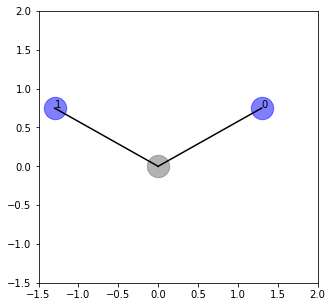

====14th kernel info====
14th-p_support:
torch.Size([2, 2])


14th-x_support:
tensor([[0.1593, 0.4640, 0.7470, 0.5546, 0.1355, 0.4109, 0.9931, 0.2764, 0.6406,
         0.5100, 0.6749, 0.3281, 0.7197, 0.9733, 0.4873, 0.0918, 0.4517, 0.9543,
         0.4809, 0.5501, 0.4176, 0.5769, 0.6741, 0.0105, 0.8413, 0.2491, 0.3151,
         0.0321, 0.6319, 0.1093, 0.3476, 0.1111, 0.3430, 0.4061, 0.5991, 0.0419,
         0.3878, 0.3418, 0.5412, 0.2858, 0.7642, 0.0212, 0.0026, 0.4292, 0.0732,
         0.5665, 0.1985, 0.1062, 0.3706, 0.5846, 0.2353, 0.6296, 0.9327, 0.9677,
         0.9368, 0.3280, 0.9611, 0.4977, 0.7166, 0.5140],
        [0.9175, 0.8799, 0.7797, 0.5101, 0.7956, 0.7099, 0.0874, 0.7962, 0.6091,
         0.5633, 0.3664, 0.9522, 0.6795, 0.9823, 0.2868, 0.5928, 0.4113, 0.8405,
         0.4421, 0.3856, 0.0931, 0.0075, 0.4598, 0.8415, 0.9510, 0.9718, 0.9180,
         0.7388, 0.2175, 0.8671, 0.3640, 0.2481, 0.7661, 0.5887, 0.3201, 0.0045,
         0.9756, 0.6475, 0.6931, 0.1368, 0.6301, 0.217

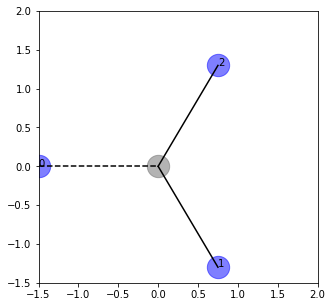

====0th kernel info====
0th-p_support:
torch.Size([3, 2])


0th-x_support:
tensor([[0.6614, 0.5912, 0.9134, 0.7684, 0.9185, 0.6132, 0.0222, 0.8517, 0.3887,
         0.1134, 0.3348, 0.1298, 0.9671, 0.1647, 0.2657, 0.1698, 0.3591, 0.1866,
         0.4233, 0.0761, 0.5762, 0.4323, 0.5277, 0.5460, 0.7888, 0.8610, 0.1680,
         0.7166, 0.0497, 0.3121, 0.9093, 0.0191, 0.9471, 0.3545, 0.8593, 0.4368,
         0.0973, 0.8015, 0.7849, 0.7869, 0.9341, 0.4015, 0.7680, 0.9156, 0.1501,
         0.5812, 0.8871, 0.8887, 0.4895, 0.4104, 0.5829, 0.0672, 0.7341, 0.7532,
         0.1831, 0.2664, 0.5674, 0.5064, 0.0174, 0.8856],
        [0.7317, 0.3711, 0.8984, 0.2414, 0.6955, 0.4364, 0.8157, 0.3452, 0.1625,
         0.0686, 0.3498, 0.9805, 0.3993, 0.2948, 0.1943, 0.7054, 0.0663, 0.7513,
         0.2206, 0.3767, 0.3643, 0.8447, 0.7771, 0.3252, 0.7932, 0.2016, 0.7665,
         0.4469, 0.3192, 0.4913, 0.4083, 0.6180, 0.1315, 0.9802, 0.1059, 0.8005,
         0.3532, 0.8413, 0.2899, 0.4329, 0.8206, 0.1271, 

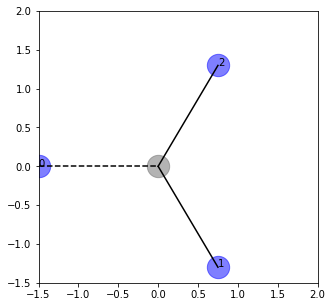

====1th kernel info====
1th-p_support:
torch.Size([3, 2])


1th-x_support:
tensor([[0.3566, 0.5994, 0.0580, 0.9915, 0.1249, 0.4832, 0.9276, 0.8468, 0.0147,
         0.4247, 0.6902, 0.8557, 0.4433, 0.1564, 0.5037, 0.1663, 0.4462, 0.5570,
         0.3268, 0.7530, 0.1815, 0.8891, 0.7194, 0.5632, 0.9783, 0.2334, 0.7971,
         0.6322, 0.7256, 0.8740, 0.5238, 0.0318, 0.9342, 0.9590, 0.9290, 0.2850,
         0.6051, 0.8855, 0.7582, 0.0413, 0.0656, 0.3051, 0.6848, 0.6184, 0.5167,
         0.3117, 0.2886, 0.6625, 0.8192, 0.6840, 0.0036, 0.6871, 0.2581, 0.2461,
         0.7721, 0.9115, 0.4191, 0.6295, 0.9545, 0.9153],
        [0.9762, 0.4657, 0.1540, 0.6998, 0.7472, 0.7738, 0.4412, 0.8315, 0.8997,
         0.0243, 0.3973, 0.1347, 0.2065, 0.9355, 0.5277, 0.6187, 0.7414, 0.3503,
         0.5637, 0.2576, 0.7222, 0.8828, 0.0180, 0.3149, 0.7298, 0.4798, 0.6085,
         0.0891, 0.8046, 0.3737, 0.6200, 0.0011, 0.5326, 0.8169, 0.9617, 0.9332,
         0.5253, 0.6332, 0.7779, 0.4083, 0.4137, 0.7248, 

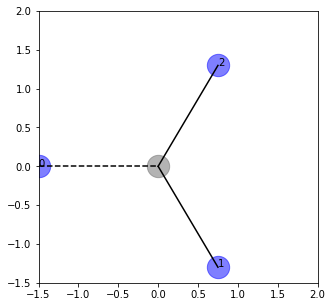

====2th kernel info====
2th-p_support:
torch.Size([3, 2])


2th-x_support:
tensor([[0.3382, 0.9625, 0.2451, 0.2744, 0.6369, 0.8665, 0.5638, 0.4024, 0.7979,
         0.5459, 0.0587, 0.5409, 0.7068, 0.8986, 0.3124, 0.3710, 0.0266, 0.5700,
         0.1652, 0.5274, 0.6190, 0.8158, 0.6310, 0.0535, 0.6516, 0.4284, 0.5108,
         0.9115, 0.5784, 0.0520, 0.9196, 0.9006, 0.6031, 0.9632, 0.3158, 0.5320,
         0.6794, 0.5167, 0.2214, 0.3001, 0.7988, 0.4016, 0.5779, 0.3768, 0.2402,
         0.3873, 0.8964, 0.0176, 0.1225, 0.5838, 0.6172, 0.5718, 0.9210, 0.2181,
         0.6839, 0.7103, 0.9614, 0.4623, 0.9787, 0.3680],
        [0.9357, 0.1737, 0.1683, 0.0356, 0.4710, 0.8990, 0.4769, 0.6879, 0.6479,
         0.5920, 0.1965, 0.4882, 0.6428, 0.1820, 0.2255, 0.8408, 0.4303, 0.4983,
         0.7051, 0.1957, 0.4319, 0.8889, 0.7073, 0.2485, 0.3334, 0.5598, 0.6636,
         0.8186, 0.3727, 0.7731, 0.6701, 0.2682, 0.4131, 0.0943, 0.0657, 0.9073,
         0.7792, 0.5909, 0.3945, 0.4892, 0.8746, 0.9028, 

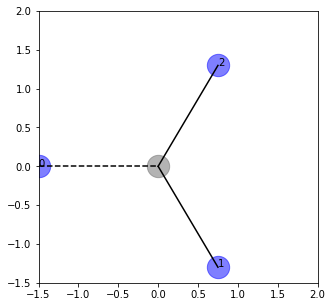

====3th kernel info====
3th-p_support:
torch.Size([3, 2])


3th-x_support:
tensor([[0.4412, 0.7013, 0.0383, 0.3713, 0.9443, 0.0850, 0.7005, 0.4780, 0.1887,
         0.4677, 0.4205, 0.2792, 0.4942, 0.3291, 0.6534, 0.0210, 0.2566, 0.9491,
         0.5768, 0.1285, 0.1778, 0.6727, 0.2158, 0.2994, 0.7134, 0.1165, 0.4414,
         0.6065, 0.9355, 0.4483, 0.1977, 0.7264, 0.0913, 0.5468, 0.5499, 0.9404,
         0.1070, 0.2741, 0.8561, 0.8916, 0.5283, 0.4899, 0.5130, 0.1696, 0.2789,
         0.3630, 0.9561, 0.0041, 0.9252, 0.4115, 0.6699, 0.8749, 0.4718, 0.4373,
         0.0685, 0.9557, 0.3659, 0.8798, 0.4263, 0.5621],
        [0.0897, 0.7664, 0.1065, 0.6500, 0.6912, 0.7057, 0.4073, 0.5626, 0.9496,
         0.3122, 0.7056, 0.6802, 0.0951, 0.7366, 0.9010, 0.1940, 0.3469, 0.9545,
         0.1838, 0.1564, 0.2383, 0.9077, 0.2752, 0.0765, 0.6039, 0.8807, 0.8640,
         0.8368, 0.5949, 0.3947, 0.4570, 0.2392, 0.4574, 0.1700, 0.5320, 0.4587,
         0.4947, 0.8550, 0.1726, 0.6250, 0.5797, 0.7244, 

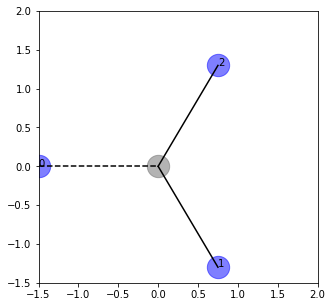

====4th kernel info====
4th-p_support:
torch.Size([3, 2])


4th-x_support:
tensor([[0.3797, 0.2051, 0.8456, 0.2595, 0.9931, 0.3244, 0.4719, 0.2946, 0.9228,
         0.5579, 0.9780, 0.1358, 0.7986, 0.6555, 0.3397, 0.1980, 0.7967, 0.3964,
         0.4111, 0.0014, 0.8461, 0.5112, 0.1057, 0.7743, 0.6353, 0.6987, 0.0036,
         0.0271, 0.6718, 0.3824, 0.9326, 0.9663, 0.1983, 0.0872, 0.0551, 0.6062,
         0.5662, 0.1764, 0.1053, 0.2518, 0.1460, 0.0522, 0.9025, 0.7552, 0.9564,
         0.5454, 0.6285, 0.0291, 0.0727, 0.9611, 0.1037, 0.5354, 0.0783, 0.8800,
         0.9719, 0.6042, 0.6317, 0.6565, 0.2976, 0.3680],
        [0.1942, 0.1682, 0.4335, 0.9148, 0.6530, 0.2986, 0.8048, 0.7059, 0.8458,
         0.1152, 0.8509, 0.0173, 0.0639, 0.0653, 0.9321, 0.5787, 0.5210, 0.9333,
         0.9419, 0.8325, 0.9903, 0.0243, 0.4118, 0.1241, 0.0096, 0.7261, 0.5796,
         0.5739, 0.5979, 0.4803, 0.9170, 0.6470, 0.9749, 0.3240, 0.8851, 0.6051,
         0.4148, 0.6841, 0.3559, 0.4465, 0.0138, 0.2868, 

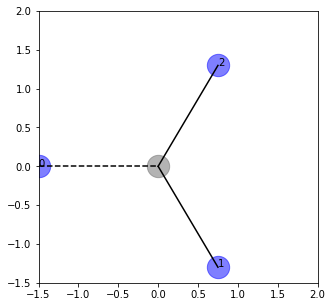

====5th kernel info====
5th-p_support:
torch.Size([3, 2])


5th-x_support:
tensor([[0.4674, 0.6249, 0.7788, 0.7241, 0.6398, 0.0889, 0.1043, 0.6389, 0.1545,
         0.9173, 0.9251, 0.2585, 0.2348, 0.8919, 0.9864, 0.6646, 0.9704, 0.1412,
         0.8234, 0.7878, 0.2836, 0.4792, 0.9065, 0.8959, 0.3270, 0.4107, 0.7438,
         0.8259, 0.6653, 0.6218, 0.5921, 0.2755, 0.3109, 0.6965, 0.0898, 0.1513,
         0.3506, 0.1563, 0.4822, 0.6635, 0.1050, 0.8959, 0.6824, 0.7959, 0.2458,
         0.8822, 0.2897, 0.3230, 0.9174, 0.4328, 0.6645, 0.9626, 0.5293, 0.9687,
         0.8930, 0.1583, 0.0934, 0.1937, 0.0931, 0.1608],
        [0.6624, 0.6992, 0.4622, 0.4942, 0.9277, 0.3015, 0.0369, 0.9752, 0.8375,
         0.7048, 0.0325, 0.6032, 0.4733, 0.8310, 0.4166, 0.3095, 0.4978, 0.7599,
         0.1007, 0.2280, 0.0050, 0.0015, 0.1554, 0.7800, 0.9489, 0.1587, 0.8907,
         0.9079, 0.4962, 0.4213, 0.8820, 0.2143, 0.9444, 0.4703, 0.3201, 0.4981,
         0.8233, 0.8779, 0.8481, 0.3178, 0.7958, 0.5592, 

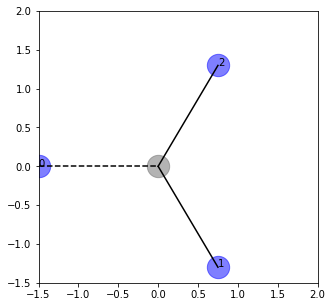

====6th kernel info====
6th-p_support:
torch.Size([3, 2])


6th-x_support:
tensor([[8.6833e-01, 9.6999e-02, 1.1510e-01, 2.3117e-01, 3.3737e-01, 6.3956e-01,
         1.3703e-01, 2.0669e-05, 4.6235e-01, 8.3392e-02, 3.7328e-01, 6.0617e-01,
         5.4619e-01, 7.4388e-01, 6.3709e-01, 5.3383e-01, 8.0175e-01, 6.0742e-01,
         8.4426e-01, 2.2058e-01, 7.0332e-01, 5.4638e-01, 6.9745e-01, 3.7855e-01,
         1.0450e-01, 7.3068e-01, 6.7260e-01, 8.3729e-01, 1.6873e-01, 2.5737e-01,
         4.5859e-01, 3.4733e-01, 2.0584e-01, 6.9400e-01, 9.2282e-01, 2.0384e-01,
         3.4836e-02, 7.7638e-02, 6.9332e-01, 5.2683e-01, 5.3487e-01, 4.7655e-02,
         9.2851e-01, 2.2022e-01, 1.4024e-02, 6.5293e-01, 6.6680e-01, 3.7319e-01,
         3.6829e-01, 4.3839e-01, 6.8843e-01, 4.6253e-01, 6.7886e-01, 6.8681e-01,
         2.9974e-01, 5.8069e-01, 6.2765e-01, 2.3984e-01, 6.5613e-01, 7.4469e-01],
        [1.4668e-01, 9.1247e-01, 7.8095e-01, 3.0162e-01, 9.3298e-01, 4.6858e-01,
         2.0950e-01, 1.5748e-01, 

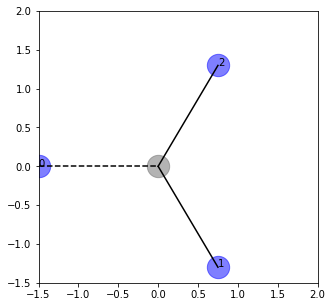

====7th kernel info====
7th-p_support:
torch.Size([3, 2])


7th-x_support:
tensor([[0.1954, 0.9693, 0.2619, 0.4741, 0.9541, 0.0019, 0.6899, 0.2484, 0.6616,
         0.9970, 0.2156, 0.9189, 0.4716, 0.7651, 0.3627, 0.5417, 0.2135, 0.4956,
         0.6663, 0.0438, 0.9300, 0.7570, 0.3852, 0.9831, 0.7771, 0.8115, 0.4961,
         0.4424, 0.8536, 0.3800, 0.1501, 0.1286, 0.9271, 0.8369, 0.0125, 0.7537,
         0.4543, 0.6039, 0.2612, 0.3814, 0.0622, 0.1525, 0.8242, 0.5606, 0.5067,
         0.8418, 0.0438, 0.2970, 0.1882, 0.0111, 0.5805, 0.6568, 0.0427, 0.1084,
         0.4497, 0.3199, 0.0408, 0.6727, 0.1316, 0.8787],
        [0.6565, 0.0673, 0.7987, 0.6429, 0.3837, 0.1924, 0.6445, 0.3953, 0.6806,
         0.2923, 0.2477, 0.0904, 0.8300, 0.0886, 0.6738, 0.4716, 0.2986, 0.8210,
         0.4729, 0.8601, 0.2391, 0.5958, 0.3098, 0.8318, 0.0997, 0.5118, 0.7669,
         0.1522, 0.9840, 0.8375, 0.4479, 0.9494, 0.6283, 0.4326, 0.2544, 0.4946,
         0.9311, 0.4561, 0.2441, 0.0250, 0.9901, 0.4296, 

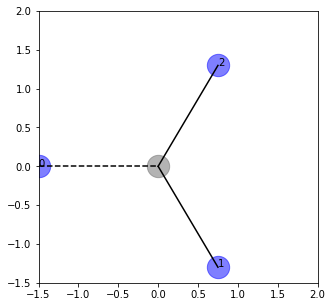

====8th kernel info====
8th-p_support:
torch.Size([3, 2])


8th-x_support:
tensor([[0.8791, 0.7978, 0.7399, 0.0148, 0.2520, 0.2007, 0.0051, 0.2555, 0.8793,
         0.6423, 0.5948, 0.9874, 0.8000, 0.4530, 0.5888, 0.0473, 0.0107, 0.6115,
         0.8745, 0.1352, 0.6511, 0.6397, 0.1975, 0.4569, 0.1579, 0.6545, 0.5553,
         0.1205, 0.7959, 0.7140, 0.5951, 0.4473, 0.5985, 0.6387, 0.9221, 0.7205,
         0.2580, 0.9995, 0.6800, 0.1320, 0.6782, 0.3108, 0.6059, 0.7092, 0.1059,
         0.2223, 0.0826, 0.0938, 0.0509, 0.6582, 0.2508, 0.9111, 0.8399, 0.4219,
         0.3606, 0.4027, 0.0677, 0.5037, 0.8762, 0.8489],
        [0.1303, 0.8487, 0.5404, 0.0146, 0.1668, 0.9370, 0.6417, 0.2129, 0.3395,
         0.9764, 0.4352, 0.1045, 0.6096, 0.0771, 0.3763, 0.6069, 0.7969, 0.2501,
         0.0687, 0.3329, 0.3158, 0.0977, 0.8221, 0.9646, 0.5517, 0.6797, 0.9936,
         0.1891, 0.9003, 0.1496, 0.6225, 0.2816, 0.2469, 0.0356, 0.6992, 0.5732,
         0.4600, 0.2264, 0.6809, 0.6509, 0.6436, 0.8526, 

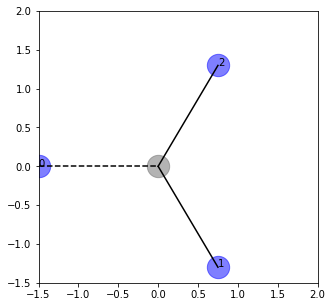

====9th kernel info====
9th-p_support:
torch.Size([3, 2])


9th-x_support:
tensor([[8.4987e-01, 8.0921e-01, 4.4269e-01, 3.3811e-01, 2.3993e-01, 7.2870e-01,
         9.1870e-02, 5.3236e-01, 5.7870e-01, 3.8682e-01, 9.7429e-02, 2.6392e-01,
         5.1985e-01, 5.9268e-02, 1.1110e-01, 5.5822e-01, 9.7640e-01, 6.4605e-01,
         9.8002e-01, 2.7030e-01, 4.2643e-01, 5.3924e-01, 6.6617e-02, 6.1546e-02,
         2.9651e-01, 9.3070e-01, 8.4121e-01, 8.3841e-01, 6.4291e-02, 1.3850e-01,
         3.4235e-01, 1.7896e-01, 8.7393e-01, 9.6177e-02, 8.8382e-01, 4.1936e-01,
         2.2868e-01, 7.9877e-01, 4.3198e-01, 5.8798e-01, 4.4363e-01, 8.9845e-01,
         3.3310e-01, 4.0655e-01, 8.7901e-02, 5.0414e-01, 9.6693e-02, 4.2075e-02,
         6.7802e-01, 1.7405e-02, 4.5736e-01, 3.4456e-01, 2.1934e-01, 1.6932e-01,
         9.6999e-01, 4.1078e-01, 8.5164e-01, 4.7875e-01, 2.9813e-01, 1.8779e-01],
        [7.1013e-01, 5.9028e-01, 2.8212e-01, 2.0149e-01, 3.8378e-01, 9.4428e-03,
         4.2430e-01, 9.3005e-01, 

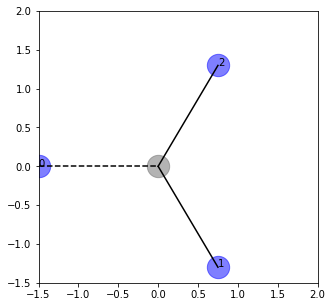

====10th kernel info====
10th-p_support:
torch.Size([3, 2])


10th-x_support:
tensor([[0.0807, 0.7419, 0.8241, 0.6533, 0.3939, 0.6289, 0.7972, 0.4754, 0.6691,
         0.6510, 0.1733, 0.1320, 0.5793, 0.7051, 0.3448, 0.4559, 0.0941, 0.8996,
         0.7457, 0.3615, 0.7766, 0.9694, 0.3598, 0.7753, 0.7141, 0.4709, 0.4136,
         0.0298, 0.2629, 0.3100, 0.6654, 0.4359, 0.4867, 0.6712, 0.6461, 0.7671,
         0.3468, 0.6382, 0.6625, 0.6930, 0.5833, 0.9618, 0.9123, 0.2483, 0.2665,
         0.4397, 0.5066, 0.1175, 0.5214, 0.8404, 0.8002, 0.7200, 0.1410, 0.4151,
         0.4285, 0.3499, 0.1892, 0.9900, 0.7837, 0.1278],
        [0.7621, 0.4182, 0.8525, 0.4074, 0.7265, 0.6881, 0.1823, 0.2850, 0.7612,
         0.3568, 0.9055, 0.7313, 0.7989, 0.3933, 0.4099, 0.5613, 0.7856, 0.4605,
         0.7409, 0.3022, 0.0522, 0.0436, 0.5715, 0.8926, 0.2555, 0.0084, 0.5596,
         0.3071, 0.1795, 0.3231, 0.3098, 0.7988, 0.8229, 0.0783, 0.9579, 0.2105,
         0.1256, 0.7442, 0.5713, 0.5112, 0.7610, 0.810

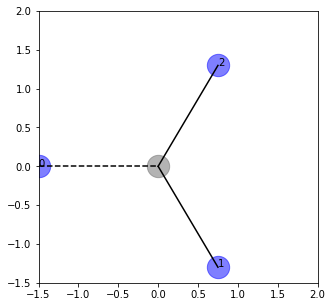

====11th kernel info====
11th-p_support:
torch.Size([3, 2])


11th-x_support:
tensor([[0.2960, 0.4837, 0.0522, 0.7896, 0.0526, 0.4419, 0.6911, 0.7861, 0.9988,
         0.0558, 0.6183, 0.3499, 0.1026, 0.6176, 0.3092, 0.2007, 0.7839, 0.7991,
         0.2924, 0.4881, 0.7869, 0.8578, 0.2409, 0.7862, 0.0171, 0.7151, 0.1351,
         0.6939, 0.5639, 0.8372, 0.8940, 0.4563, 0.7919, 0.8479, 0.4310, 0.6324,
         0.1254, 0.2240, 0.9940, 0.4096, 0.0328, 0.2844, 0.0607, 0.9016, 0.3122,
         0.2815, 0.1592, 0.3584, 0.6537, 0.8202, 0.4788, 0.4313, 0.8182, 0.4429,
         0.4941, 0.1177, 0.1299, 0.0235, 0.4752, 0.3104],
        [0.0345, 0.9420, 0.5359, 0.9108, 0.5837, 0.5036, 0.6621, 0.5700, 0.4098,
         0.8298, 0.6001, 0.1370, 0.1626, 0.1297, 0.3006, 0.3313, 0.2988, 0.6640,
         0.1196, 0.4687, 0.9791, 0.7463, 0.6177, 0.6372, 0.7584, 0.2182, 0.0442,
         0.9299, 0.5065, 0.3754, 0.4978, 0.5345, 0.5014, 0.9510, 0.6226, 0.0910,
         0.0523, 0.4616, 0.0942, 0.2904, 0.1278, 0.739

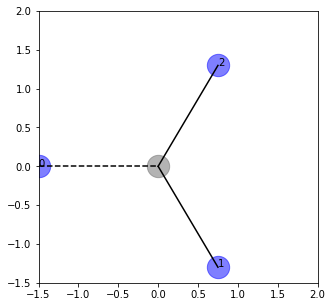

====12th kernel info====
12th-p_support:
torch.Size([3, 2])


12th-x_support:
tensor([[0.0109, 0.4759, 0.0300, 0.4020, 0.4293, 0.9892, 0.1551, 0.8216, 0.8539,
         0.8165, 0.2346, 0.1385, 0.0093, 0.5539, 0.9051, 0.1184, 0.5055, 0.0871,
         0.7735, 0.8497, 0.1669, 0.7559, 0.3798, 0.2620, 0.1731, 0.5472, 0.4863,
         0.8810, 0.8128, 0.6893, 0.5261, 0.2775, 0.1603, 0.4280, 0.3316, 0.9701,
         0.4256, 0.1707, 0.9314, 0.3869, 0.7187, 0.3433, 0.4782, 0.6076, 0.7158,
         0.2160, 0.8672, 0.9799, 0.4819, 0.6009, 0.1879, 0.8150, 0.1424, 0.9140,
         0.4327, 0.1611, 0.2941, 0.9697, 0.8140, 0.2618],
        [0.9324, 0.0223, 0.9800, 0.6604, 0.9283, 0.4935, 0.1418, 0.9751, 0.7683,
         0.1065, 0.7954, 0.2236, 0.2213, 0.8782, 0.1615, 0.7427, 0.9692, 0.5724,
         0.6153, 0.2945, 0.1836, 0.5419, 0.9846, 0.0160, 0.1142, 0.0641, 0.9523,
         0.0533, 0.1282, 0.4087, 0.5812, 0.4291, 0.6485, 0.7290, 0.1351, 0.2514,
         0.5023, 0.2522, 0.4935, 0.2477, 0.6228, 0.384

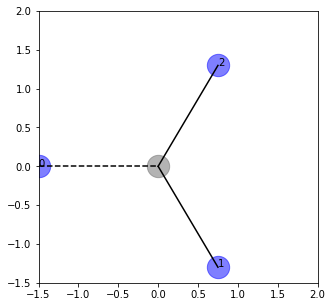

====13th kernel info====
13th-p_support:
torch.Size([3, 2])


13th-x_support:
tensor([[0.4576, 0.4308, 0.2160, 0.2672, 0.7506, 0.2881, 0.1141, 0.1816, 0.0352,
         0.0049, 0.4704, 0.4006, 0.6653, 0.0024, 0.4749, 0.7706, 0.1117, 0.8432,
         0.2343, 0.1734, 0.5701, 0.0761, 0.1157, 0.1131, 0.7345, 0.5790, 0.2552,
         0.1579, 0.5777, 0.8493, 0.4587, 0.4973, 0.0908, 0.8014, 0.3424, 0.3225,
         0.2629, 0.1888, 0.8441, 0.0971, 0.1686, 0.2753, 0.9758, 0.8749, 0.9892,
         0.0049, 0.7229, 0.2699, 0.5628, 0.0264, 0.8029, 0.7031, 0.8178, 0.8732,
         0.0826, 0.1968, 0.5736, 0.8359, 0.7278, 0.9818],
        [0.4159, 0.0172, 0.8581, 0.2409, 0.5647, 0.3872, 0.3401, 0.7310, 0.8662,
         0.9176, 0.5427, 0.6667, 0.8878, 0.9677, 0.1804, 0.9502, 0.3250, 0.0738,
         0.4932, 0.0788, 0.9274, 0.7790, 0.6966, 0.1744, 0.9746, 0.6604, 0.7874,
         0.3345, 0.5921, 0.8840, 0.5563, 0.2446, 0.7596, 0.6180, 0.3737, 0.5627,
         0.3726, 0.9932, 0.5908, 0.1324, 0.5956, 0.772

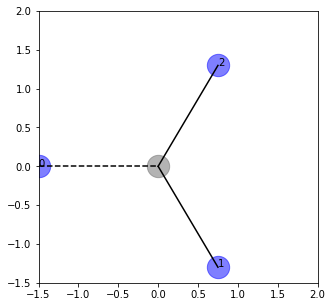

====14th kernel info====
14th-p_support:
torch.Size([3, 2])


14th-x_support:
tensor([[0.3545, 0.0235, 0.8829, 0.7311, 0.6895, 0.9003, 0.6799, 0.5829, 0.5997,
         0.8079, 0.2024, 0.7630, 0.4272, 0.4755, 0.9009, 0.1109, 0.0975, 0.5864,
         0.3740, 0.9680, 0.5350, 0.2079, 0.6116, 0.2529, 0.3414, 0.4474, 0.1654,
         0.7997, 0.3468, 0.1935, 0.2846, 0.2575, 0.1836, 0.4052, 0.7663, 0.4364,
         0.4593, 0.0736, 0.0505, 0.8784, 0.8253, 0.0477, 0.0108, 0.3726, 0.5735,
         0.0510, 0.1524, 0.2647, 0.3757, 0.5191, 0.2518, 0.0858, 0.7658, 0.0389,
         0.6038, 0.2698, 0.7755, 0.0456, 0.0571, 0.7980],
        [0.0847, 0.5433, 0.7912, 0.2849, 0.7169, 0.5536, 0.8482, 0.4825, 0.2941,
         0.2061, 0.8899, 0.2236, 0.9287, 0.0031, 0.4200, 0.6952, 0.5016, 0.1961,
         0.0083, 0.7115, 0.9774, 0.4134, 0.5272, 0.3020, 0.8149, 0.8324, 0.8587,
         0.6149, 0.3145, 0.1270, 0.1289, 0.9337, 0.3049, 0.0252, 0.1303, 0.9322,
         0.5573, 0.4184, 0.6891, 0.1136, 0.7672, 0.409

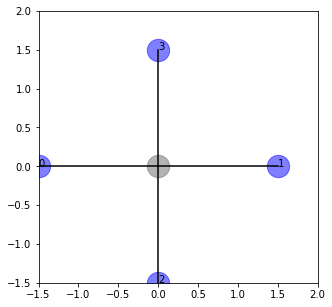

====0th kernel info====
0th-p_support:
torch.Size([4, 2])


0th-x_support:
tensor([[0.4455, 0.0332, 0.1389, 0.2634, 0.9247, 0.9617, 0.2141, 0.6458, 0.2163,
         0.8813, 0.2941, 0.8835, 0.3991, 0.4657, 0.6782, 0.2791, 0.9203, 0.9316,
         0.7567, 0.8785, 0.2327, 0.3219, 0.3662, 0.4728, 0.3027, 0.4686, 0.6880,
         0.7568, 0.7770, 0.5739, 0.1599, 0.9366, 0.1051, 0.2487, 0.8173, 0.4740,
         0.1757, 0.2203, 0.5257, 0.4948, 0.0163, 0.7385, 0.2325, 0.7047, 0.5624,
         0.6830, 0.5968, 0.2690, 0.1409, 0.2372, 0.0554, 0.2933, 0.3360, 0.9448,
         0.6504, 0.0775, 0.9051, 0.3600, 0.9003, 0.8574],
        [0.9286, 0.7608, 0.1963, 0.5108, 0.1524, 0.3081, 0.1376, 0.8415, 0.6775,
         0.0426, 0.4216, 0.2578, 0.7952, 0.3548, 0.8592, 0.3883, 0.3922, 0.5694,
         0.2524, 0.1507, 0.7622, 0.2913, 0.3015, 0.6996, 0.3436, 0.9861, 0.3124,
         0.6905, 0.1881, 0.4008, 0.3268, 0.1364, 0.2858, 0.8721, 0.1799, 0.4893,
         0.7863, 0.7970, 0.7295, 0.3841, 0.9883, 0.3344, 

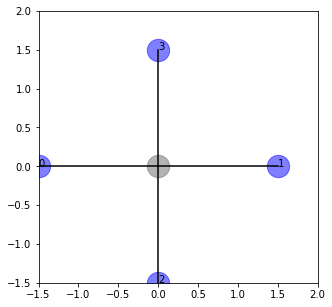

====1th kernel info====
1th-p_support:
torch.Size([4, 2])


1th-x_support:
tensor([[8.0278e-01, 4.2668e-01, 2.6118e-01, 4.3816e-01, 7.6075e-02, 2.0293e-02,
         4.7649e-03, 8.2303e-01, 9.5105e-01, 7.1101e-01, 3.7334e-01, 7.3462e-01,
         5.6596e-02, 4.3650e-01, 5.8882e-01, 7.9053e-01, 4.1158e-01, 5.3253e-01,
         1.1676e-01, 6.8110e-01, 9.7671e-01, 1.4136e-01, 3.7533e-01, 9.2990e-01,
         7.1481e-01, 6.9300e-02, 7.1637e-01, 7.5496e-01, 8.5880e-01, 1.0575e-01,
         9.5719e-01, 1.1636e-02, 7.0472e-01, 8.4725e-02, 8.7067e-01, 3.3356e-01,
         5.2138e-01, 6.3878e-01, 7.2197e-01, 3.0708e-01, 3.4109e-01, 5.7026e-01,
         9.7559e-02, 2.3624e-02, 1.4244e-01, 6.8921e-01, 3.8785e-01, 6.0213e-01,
         7.5345e-02, 9.1264e-02, 1.2722e-01, 1.8359e-01, 6.5015e-01, 4.9400e-01,
         9.8657e-01, 2.4842e-01, 4.6628e-01, 1.0425e-01, 9.4706e-01, 7.2150e-01],
        [1.8632e-02, 5.0148e-02, 5.6324e-01, 3.5962e-01, 1.9214e-01, 1.4257e-01,
         2.6179e-01, 6.5017e-01, 

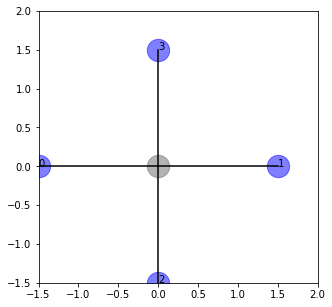

====2th kernel info====
2th-p_support:
torch.Size([4, 2])


2th-x_support:
tensor([[0.7114, 0.5367, 0.7088, 0.5515, 0.4552, 0.7722, 0.9089, 0.0507, 0.8243,
         0.9824, 0.6973, 0.3550, 0.9223, 0.9782, 0.7552, 0.2815, 0.6745, 0.6958,
         0.6421, 0.6993, 0.4800, 0.3962, 0.1968, 0.1191, 0.7211, 0.4150, 0.9586,
         0.0824, 0.4961, 0.7262, 0.3661, 0.2131, 0.4487, 0.4479, 0.1022, 0.7734,
         0.5658, 0.5951, 0.5458, 0.5414, 0.5071, 0.3416, 0.7813, 0.1650, 0.3051,
         0.4934, 0.4427, 0.8615, 0.2321, 0.2986, 0.3130, 0.7845, 0.2231, 0.8727,
         0.7113, 0.5040, 0.1441, 0.0584, 0.7288, 0.3066],
        [0.6741, 0.7979, 0.2280, 0.0120, 0.5868, 0.3666, 0.3516, 0.0252, 0.7283,
         0.5227, 0.7691, 0.4056, 0.1473, 0.9675, 0.3460, 0.6570, 0.6676, 0.1096,
         0.0035, 0.3395, 0.2416, 0.6085, 0.1254, 0.2305, 0.4520, 0.3419, 0.7239,
         0.0826, 0.3619, 0.0013, 0.3490, 0.2631, 0.9468, 0.3803, 0.8046, 0.8244,
         0.9095, 0.1959, 0.3068, 0.9518, 0.3194, 0.4844, 

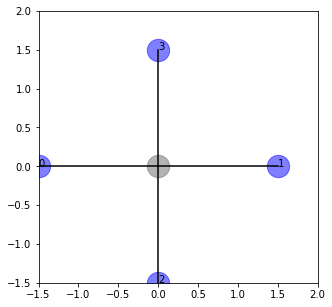

====3th kernel info====
3th-p_support:
torch.Size([4, 2])


3th-x_support:
tensor([[0.4000, 0.0142, 0.9125, 0.2672, 0.5021, 0.0703, 0.6596, 0.7236, 0.6325,
         0.2798, 0.9233, 0.9408, 0.6758, 0.2348, 0.0049, 0.1521, 0.3494, 0.0336,
         0.4750, 0.5994, 0.6623, 0.6254, 0.5839, 0.8220, 0.5105, 0.8173, 0.6606,
         0.1323, 0.6297, 0.3644, 0.0682, 0.0755, 0.6441, 0.5565, 0.4922, 0.2302,
         0.8202, 0.9302, 0.0892, 0.2135, 0.6060, 0.4117, 0.3467, 0.1221, 0.9319,
         0.6872, 0.6490, 0.7220, 0.7380, 0.2860, 0.7910, 0.5995, 0.2063, 0.9936,
         0.6110, 0.0071, 0.6901, 0.8487, 0.3058, 0.7651],
        [0.6372, 0.1528, 0.9917, 0.7995, 0.7103, 0.9111, 0.3241, 0.8397, 0.8363,
         0.5589, 0.8890, 0.6916, 0.7418, 0.2176, 0.6911, 0.5226, 0.9499, 0.8253,
         0.7601, 0.9381, 0.2941, 0.3303, 0.6438, 0.3459, 0.2148, 0.5750, 0.7757,
         0.9467, 0.7043, 0.6332, 0.5234, 0.2313, 0.8762, 0.1623, 0.7094, 0.4551,
         0.6750, 0.8218, 0.0610, 0.6371, 0.7553, 0.8062, 

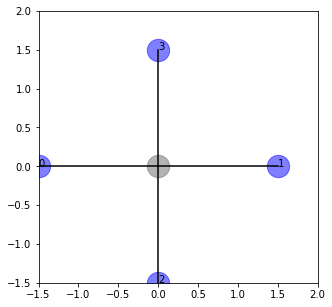

====4th kernel info====
4th-p_support:
torch.Size([4, 2])


4th-x_support:
tensor([[0.0745, 0.1949, 0.0415, 0.2263, 0.4919, 0.2591, 0.0210, 0.7722, 0.3310,
         0.3514, 0.9834, 0.4063, 0.4771, 0.0139, 0.8536, 0.2043, 0.2986, 0.4295,
         0.3157, 0.1746, 0.7217, 0.3122, 0.3347, 0.9238, 0.4168, 0.1892, 0.2853,
         0.1387, 0.2834, 0.4381, 0.9533, 0.5858, 0.4565, 0.3924, 0.7636, 0.4861,
         0.9457, 0.8523, 0.5091, 0.4756, 0.8339, 0.3376, 0.8001, 0.9975, 0.9562,
         0.9845, 0.8803, 0.4075, 0.3572, 0.5442, 0.1948, 0.4513, 0.4648, 0.3779,
         0.3131, 0.4815, 0.8410, 0.4193, 0.8551, 0.7006],
        [0.6853, 0.0582, 0.7234, 0.1957, 0.6045, 0.5851, 0.2092, 0.4829, 0.1549,
         0.0474, 0.6816, 0.2451, 0.9156, 0.6898, 0.0786, 0.8869, 0.8041, 0.5476,
         0.8045, 0.5969, 0.1927, 0.0699, 0.7598, 0.5343, 0.9413, 0.5480, 0.8200,
         0.6783, 0.8101, 0.6131, 0.2000, 0.6496, 0.6824, 0.0542, 0.6153, 0.7892,
         0.2590, 0.1967, 0.1717, 0.3868, 0.3607, 0.5083, 

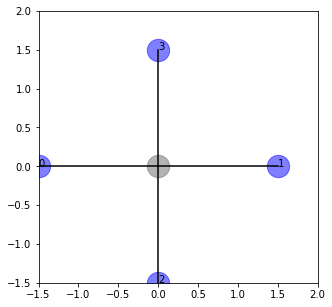

====5th kernel info====
5th-p_support:
torch.Size([4, 2])


5th-x_support:
tensor([[0.8873, 0.4906, 0.7989, 0.0672, 0.3278, 0.7410, 0.1149, 0.7947, 0.3221,
         0.5278, 0.3787, 0.4129, 0.4889, 0.5593, 0.2995, 0.0493, 0.1155, 0.2287,
         0.7113, 0.0928, 0.1185, 0.6429, 0.9662, 0.4869, 0.4957, 0.7734, 0.6407,
         0.2115, 0.8406, 0.9150, 0.1871, 0.2660, 0.4953, 0.6770, 0.2686, 0.6240,
         0.1274, 0.7236, 0.7823, 0.1059, 0.7211, 0.0509, 0.7703, 0.2842, 0.7448,
         0.4714, 0.8704, 0.7648, 0.6614, 0.1467, 0.9394, 0.3522, 0.2108, 0.8324,
         0.8428, 0.3430, 0.3415, 0.7321, 0.0680, 0.8341],
        [0.2963, 0.0362, 0.9014, 0.9187, 0.4854, 0.8756, 0.0233, 0.4244, 0.5668,
         0.2982, 0.9794, 0.5501, 0.7465, 0.6579, 0.1844, 0.0546, 0.5701, 0.5394,
         0.9261, 0.9530, 0.3360, 0.5012, 0.0975, 0.8878, 0.7655, 0.7226, 0.6647,
         0.0165, 0.1289, 0.4034, 0.2001, 0.7627, 0.7772, 0.4518, 0.7976, 0.9807,
         0.2694, 0.2896, 0.4637, 0.0843, 0.8542, 0.1345, 

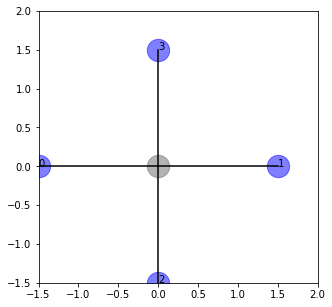

====6th kernel info====
6th-p_support:
torch.Size([4, 2])


6th-x_support:
tensor([[0.1994, 0.8384, 0.7790, 0.8839, 0.4339, 0.1366, 0.1618, 0.3949, 0.9063,
         0.5029, 0.0181, 0.1370, 0.7953, 0.7251, 0.4833, 0.4879, 0.5917, 0.5173,
         0.5457, 0.0699, 0.8188, 0.0751, 0.4073, 0.1203, 0.6121, 0.1865, 0.8351,
         0.2633, 0.9010, 0.5946, 0.8104, 0.0995, 0.0520, 0.2718, 0.3980, 0.6167,
         0.5508, 0.7364, 0.6511, 0.2606, 0.1715, 0.9043, 0.9507, 0.2699, 0.5999,
         0.9001, 0.1572, 0.0404, 0.0478, 0.9367, 0.4070, 0.1911, 0.3601, 0.8109,
         0.2883, 0.2137, 0.9991, 0.2561, 0.0194, 0.5131],
        [0.7762, 0.0815, 0.8840, 0.4907, 0.3429, 0.2149, 0.3888, 0.4375, 0.8750,
         0.2652, 0.1984, 0.8927, 0.5021, 0.5750, 0.9972, 0.5586, 0.7989, 0.6822,
         0.9300, 0.1389, 0.0626, 0.3256, 0.7190, 0.5958, 0.3214, 0.4556, 0.0938,
         0.8578, 0.7178, 0.8613, 0.8142, 0.9050, 0.2555, 0.7753, 0.9774, 0.3186,
         0.4860, 0.3402, 0.4238, 0.2079, 0.2325, 0.0226, 

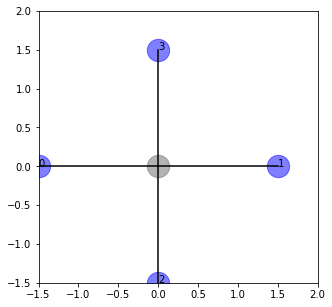

====7th kernel info====
7th-p_support:
torch.Size([4, 2])


7th-x_support:
tensor([[0.0710, 0.7546, 0.2407, 0.6825, 0.8498, 0.6016, 0.8900, 0.3011, 0.8844,
         0.0306, 0.2266, 0.8112, 0.9591, 0.2622, 0.5612, 0.9760, 0.9835, 0.8148,
         0.8885, 0.7523, 0.1868, 0.8970, 0.8307, 0.0365, 0.2145, 0.0070, 0.7916,
         0.0204, 0.1735, 0.6330, 0.1881, 0.9095, 0.1923, 0.6177, 0.7218, 0.4040,
         0.4856, 0.6045, 0.7555, 0.3703, 0.2063, 0.8349, 0.0797, 0.9853, 0.3391,
         0.1940, 0.9521, 0.4101, 0.8950, 0.8139, 0.9827, 0.8268, 0.3900, 0.0198,
         0.8744, 0.3701, 0.2603, 0.3783, 0.2859, 0.7409],
        [0.2233, 0.8818, 0.5345, 0.1503, 0.8878, 0.3839, 0.5032, 0.9255, 0.8893,
         0.5418, 0.5574, 0.4425, 0.0035, 0.0120, 0.8459, 0.3081, 0.8870, 0.9052,
         0.3610, 0.0922, 0.0784, 0.8900, 0.2512, 0.5058, 0.1185, 0.8020, 0.1797,
         0.4196, 0.4847, 0.1124, 0.1233, 0.7880, 0.5514, 0.7370, 0.6051, 0.3915,
         0.7759, 0.6745, 0.9522, 0.3941, 0.2026, 0.5807, 

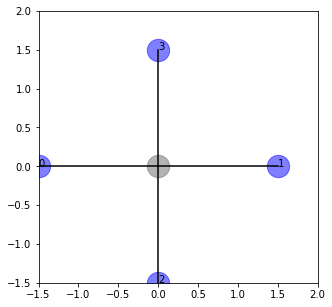

====8th kernel info====
8th-p_support:
torch.Size([4, 2])


8th-x_support:
tensor([[0.0357, 0.7509, 0.4695, 0.3263, 0.5930, 0.8838, 0.5265, 0.0890, 0.7685,
         0.4951, 0.1464, 0.6415, 0.2339, 0.9602, 0.4622, 0.8944, 0.2489, 0.8199,
         0.8778, 0.7672, 0.7842, 0.6631, 0.2226, 0.3403, 0.4328, 0.8007, 0.4288,
         0.0399, 0.3482, 0.3975, 0.1758, 0.2204, 0.6752, 0.8574, 0.2942, 0.1042,
         0.9450, 0.9899, 0.3318, 0.2251, 0.0238, 0.8661, 0.0029, 0.7099, 0.5314,
         0.6819, 0.2640, 0.5535, 0.5367, 0.0897, 0.1298, 0.0448, 0.6048, 0.8087,
         0.1522, 0.6175, 0.8447, 0.5996, 0.9292, 0.3017],
        [0.0995, 0.0154, 0.1341, 0.0174, 0.4310, 0.5034, 0.5787, 0.1544, 0.5156,
         0.4711, 0.4301, 0.3712, 0.4909, 0.9936, 0.8786, 0.2834, 0.7615, 0.9718,
         0.9284, 0.1594, 0.0582, 0.5284, 0.6098, 0.5511, 0.9238, 0.9691, 0.5458,
         0.1076, 0.9355, 0.3847, 0.8403, 0.0674, 0.1713, 0.2897, 0.4553, 0.3507,
         0.9161, 0.7972, 0.1331, 0.4058, 0.3058, 0.3809, 

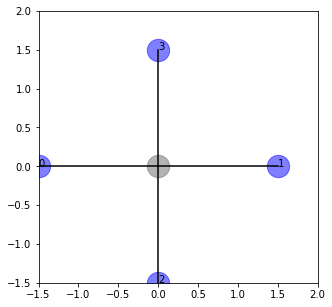

====9th kernel info====
9th-p_support:
torch.Size([4, 2])


9th-x_support:
tensor([[0.3459, 0.5165, 0.9067, 0.3590, 0.0349, 0.3980, 0.2996, 0.3227, 0.6906,
         0.4456, 0.9453, 0.3710, 0.2148, 0.0718, 0.9973, 0.2157, 0.9268, 0.7247,
         0.2459, 0.1941, 0.4026, 0.5634, 0.6103, 0.8260, 0.7200, 0.9398, 0.7719,
         0.4704, 0.7159, 0.8143, 0.4997, 0.2709, 0.8778, 0.3050, 0.5196, 0.7107,
         0.2273, 0.9049, 0.7448, 0.2702, 0.1290, 0.8985, 0.8391, 0.9174, 0.3109,
         0.5032, 0.6454, 0.3668, 0.6827, 0.5058, 0.7647, 0.4278, 0.5013, 0.6496,
         0.2424, 0.0090, 0.2683, 0.8052, 0.3141, 0.5082],
        [0.7616, 0.3829, 0.7395, 0.9457, 0.5609, 0.5695, 0.7782, 0.8958, 0.7685,
         0.2669, 0.2277, 0.4639, 0.9110, 0.3283, 0.3007, 0.3874, 0.0491, 0.2810,
         0.9887, 0.2410, 0.8233, 0.2517, 0.1657, 0.8694, 0.7567, 0.7463, 0.9488,
         0.7862, 0.7957, 0.6206, 0.9191, 0.2829, 0.7687, 0.1353, 0.9910, 0.5380,
         0.3096, 0.4951, 0.5627, 0.6436, 0.6744, 0.9936, 

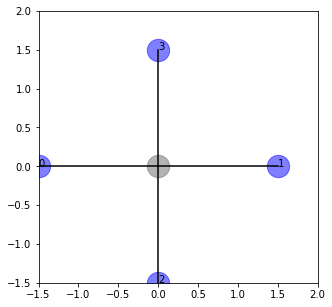

====10th kernel info====
10th-p_support:
torch.Size([4, 2])


10th-x_support:
tensor([[3.1655e-01, 2.7048e-01, 3.9463e-01, 5.2481e-01, 9.6032e-01, 8.9385e-01,
         9.7090e-01, 8.6502e-01, 4.6876e-01, 5.3718e-01, 6.6831e-02, 9.1214e-01,
         9.7613e-01, 2.9800e-01, 7.7775e-01, 9.2723e-01, 4.3142e-01, 3.3493e-01,
         2.7345e-01, 4.4570e-01, 2.6016e-01, 3.7877e-01, 2.9909e-01, 4.4729e-01,
         5.4755e-02, 1.2454e-01, 5.7961e-02, 1.9383e-01, 8.2801e-01, 6.7295e-01,
         9.8891e-01, 9.8702e-01, 2.6120e-01, 4.1626e-01, 3.0667e-01, 3.8946e-01,
         5.2179e-01, 5.7635e-01, 1.5593e-01, 1.7553e-01, 4.6749e-02, 4.5403e-01,
         1.8990e-01, 1.9886e-01, 7.5613e-01, 6.5523e-01, 9.4141e-01, 7.3341e-02,
         1.8371e-01, 4.4384e-01, 5.3420e-02, 5.6025e-01, 7.4957e-01, 4.8039e-01,
         4.5937e-05, 8.5112e-01, 4.9889e-01, 1.0159e-01, 2.3744e-01, 9.2547e-02],
        [2.4474e-01, 6.2667e-01, 7.4937e-01, 2.4867e-01, 7.8901e-01, 1.8430e-01,
         6.8186e-01, 3.7724e-0

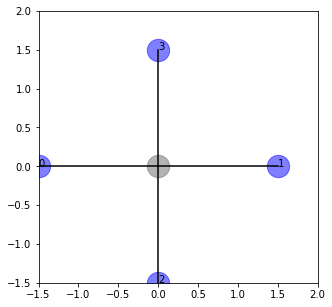

====11th kernel info====
11th-p_support:
torch.Size([4, 2])


11th-x_support:
tensor([[0.9362, 0.8852, 0.4398, 0.0375, 0.8034, 0.6594, 0.0188, 0.3234, 0.3860,
         0.1986, 0.4908, 0.2555, 0.4361, 0.8726, 0.5689, 0.2554, 0.5259, 0.7837,
         0.2346, 0.4858, 0.5104, 0.7807, 0.7462, 0.6126, 0.2376, 0.8261, 0.8834,
         0.9435, 0.1190, 0.5418, 0.6952, 0.4339, 0.2970, 0.9940, 0.9135, 0.0842,
         0.6231, 0.1880, 0.1010, 0.3950, 0.3306, 0.7401, 0.2795, 0.0944, 0.1545,
         0.7364, 0.8763, 0.0454, 0.6447, 0.7221, 0.5231, 0.2741, 0.1946, 0.9491,
         0.9005, 0.5818, 0.8335, 0.3255, 0.0461, 0.9842],
        [0.0795, 0.3996, 0.1442, 0.6013, 0.3376, 0.6094, 0.9461, 0.0840, 0.5968,
         0.0965, 0.9531, 0.2005, 0.6712, 0.8888, 0.9850, 0.6701, 0.0819, 0.4322,
         0.6356, 0.8187, 0.5637, 0.5114, 0.6950, 0.1006, 0.6758, 0.9491, 0.8339,
         0.2450, 0.9143, 0.3685, 0.0395, 0.4827, 0.2700, 0.1873, 0.0033, 0.2755,
         0.0576, 0.6984, 0.0670, 0.6444, 0.4856, 0.369

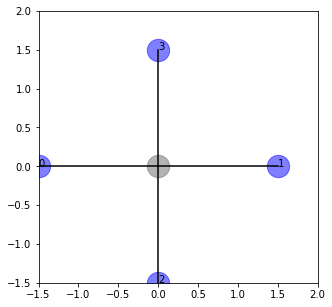

====12th kernel info====
12th-p_support:
torch.Size([4, 2])


12th-x_support:
tensor([[0.9076, 0.8869, 0.9648, 0.8516, 0.6523, 0.7223, 0.4674, 0.8456, 0.6941,
         0.8857, 0.0917, 0.8687, 0.4059, 0.9648, 0.6724, 0.9648, 0.6634, 0.7494,
         0.2919, 0.2858, 0.5653, 0.6247, 0.3396, 0.2217, 0.0109, 0.7188, 0.1996,
         0.1827, 0.7384, 0.7722, 0.6436, 0.7663, 0.0756, 0.3333, 0.3038, 0.3331,
         0.1524, 0.1331, 0.6438, 0.3666, 0.6694, 0.2067, 0.6986, 0.0832, 0.7927,
         0.8870, 0.9689, 0.6988, 0.3622, 0.8347, 0.6200, 0.1460, 0.5338, 0.4623,
         0.0923, 0.2606, 0.9509, 0.6075, 0.3361, 0.1317],
        [0.9974, 0.0285, 0.3970, 0.9475, 0.0403, 0.4616, 0.9508, 0.0353, 0.9074,
         0.2063, 0.5956, 0.8347, 0.1516, 0.2881, 0.6701, 0.7278, 0.5098, 0.9206,
         0.0031, 0.0600, 0.6708, 0.0255, 0.5669, 0.7707, 0.9771, 0.7325, 0.0870,
         0.4720, 0.9890, 0.1325, 0.2394, 0.6714, 0.4622, 0.3280, 0.5453, 0.5749,
         0.3190, 0.5090, 0.7183, 0.4530, 0.1037, 0.544

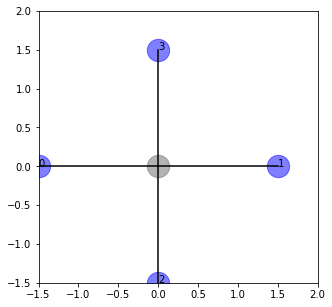

====13th kernel info====
13th-p_support:
torch.Size([4, 2])


13th-x_support:
tensor([[8.6064e-01, 1.9565e-02, 8.9417e-01, 4.5844e-01, 5.2507e-01, 2.0624e-01,
         1.9733e-02, 9.6955e-01, 7.9001e-01, 8.9697e-01, 5.9152e-01, 8.1467e-02,
         6.8042e-01, 3.5016e-01, 7.9494e-01, 7.8300e-01, 2.3844e-01, 7.7057e-01,
         8.2538e-01, 3.7360e-01, 9.6197e-01, 1.9296e-01, 7.0709e-01, 1.9266e-01,
         7.2735e-01, 2.6415e-01, 9.6664e-01, 3.1631e-01, 8.5137e-01, 1.0060e-02,
         5.6891e-01, 4.3994e-02, 4.7626e-01, 2.6552e-01, 8.8215e-01, 7.3372e-01,
         8.4092e-01, 2.8365e-01, 4.7723e-01, 8.9991e-01, 1.3026e-01, 1.7537e-01,
         3.5757e-01, 2.1140e-02, 1.8856e-01, 1.1561e-01, 1.1978e-02, 4.4395e-01,
         5.0502e-01, 6.7311e-01, 9.7210e-01, 4.3316e-01, 1.8574e-01, 5.8379e-02,
         8.4386e-01, 1.3500e-01, 1.7170e-01, 1.0468e-01, 4.8357e-02, 1.6091e-01],
        [4.5325e-03, 5.7094e-02, 7.6909e-01, 5.7111e-01, 2.9002e-01, 6.9614e-01,
         7.5307e-01, 6.2848e-0

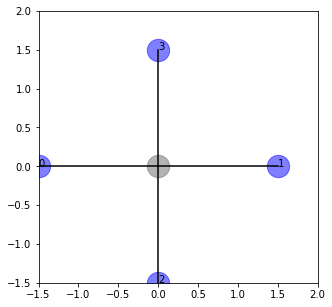

====14th kernel info====
14th-p_support:
torch.Size([4, 2])


14th-x_support:
tensor([[0.2213, 0.0533, 0.4336, 0.7615, 0.4698, 0.5441, 0.7511, 0.9825, 0.3407,
         0.2618, 0.0168, 0.0600, 0.4534, 0.0035, 0.9599, 0.5461, 0.6017, 0.8426,
         0.6530, 0.2213, 0.5250, 0.6839, 0.2696, 0.9057, 0.1390, 0.3264, 0.9142,
         0.4912, 0.2279, 0.1203, 0.1537, 0.3651, 0.2072, 0.2103, 0.3377, 0.3056,
         0.6007, 0.7919, 0.6907, 0.9080, 0.6871, 0.9250, 0.5764, 0.6770, 0.2172,
         0.3030, 0.0139, 0.7851, 0.7506, 0.9596, 0.3909, 0.3542, 0.8209, 0.8991,
         0.1268, 0.8471, 0.8125, 0.6525, 0.0143, 0.7353],
        [0.2843, 0.6220, 0.1902, 0.1847, 0.9756, 0.2984, 0.0724, 0.7997, 0.9197,
         0.0609, 0.8289, 0.6604, 0.9260, 0.6650, 0.1766, 0.6270, 0.4831, 0.1781,
         0.4752, 0.4330, 0.1684, 0.3287, 0.5190, 0.3884, 0.5524, 0.8585, 0.9097,
         0.2463, 0.1603, 0.0523, 0.3420, 0.8061, 0.3165, 0.6480, 0.5519, 0.7104,
         0.0763, 0.5715, 0.4618, 0.0138, 0.7879, 0.109

In [25]:
# visualize saved model kernels
model = PredefinedNHopKernelSetConv(D=2, node_attr_dim=60, edge_attr_dim=1, L1=15, L2=15, L3=15, L4=15)
model.load_state_dict(torch.load('../saved_kernellayers/4th_layer.pth'))

print(list(model.state_dict()))
vis_kernel_in_kernelsetconv(model)